#Implementation OF PRO-GAN for Generative Dog Image

Mounting drive to access dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/MyDrive/Project/all-dogs.zip'

# Path where you want to extract the contents of the zip file
extract_path = '/content/drive/MyDrive/Project/'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the files and folders to the desired path
    zip_ref.extractall(extract_path)
    print("Extraction completed.")


Extraction completed.


In [ ]:
# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/MyDrive/Project/Annotation.zip'

# Path where you want to extract the contents of the zip file
extract_path = '/content/drive/MyDrive/Project/'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the files and folders to the desired path
    zip_ref.extractall(extract_path)
    print("Extraction completed.")

Extraction completed.


In [ ]:
import re
import gc
import os
import cv2
import copy
import time
import pickle
import random
import shutil
import urllib
import pathlib
import datetime
import operator
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from PIL import Image
from scipy import linalg
from sklearn.metrics import *
from collections import Counter
from scipy.stats import truncnorm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool, cpu_count
from sklearn.preprocessing import LabelEncoder

import torch
import torch as th
import torch.nn as nn
import torch.utils.data
import torchvision as tv
import torch.nn.functional as F
import torchvision.models as models

from torch.optim import Adam
from torch.nn import Parameter

from torchvision.datasets import *
from torch.autograd import Variable
from torch.optim.lr_scheduler import *
from torchvision.utils import save_image
from torchvision.datasets.folder import *
from torch.nn.functional import interpolate
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import Conv2d, BCEWithLogitsLoss, DataParallel, AvgPool2d, ModuleList, LeakyReLU, ConvTranspose2d, Embedding

begin = time.time()
sns.set_style('white')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [ ]:
KERNEL_START_TIME = time.time()

Defining path for images and annotations

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Project/all-dogs/'
IMAGE_FOLDER = '/content/drive/MyDrive/Project/all-dogs'
IMAGES = [DATA_PATH + p for p in os.listdir(DATA_PATH)]
ANNOTATION_PATH = '/content/drive/MyDrive/Project/Annotation'

Total Images

In [ ]:
print('Number of dog images :', len(IMAGES))

Number of dog images : 20579


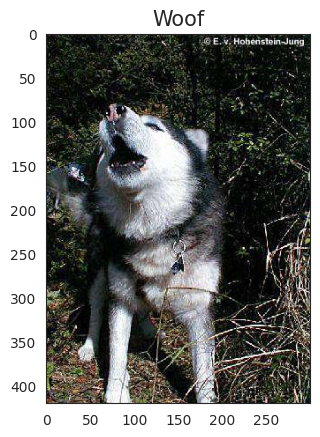

In [ ]:
img = Image.open(IMAGES[0])
plt.imshow(img)
plt.title('Woof', size=15)
plt.show()

Using seed to get an optimized set of random numbers

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

In [ ]:
seed = 2019
seed_everything(seed)

Data Pre-Processing

In [ ]:
class Rescale:
    def __init__(self):
        self.a = 2
        self.b = -1

    def __call__(self, tensor):
        return tensor.mul(self.a).add(self.b)

    def __repr__(self):
        return f"{self.__class__.__name__}(a={self.a}, b={self.b})"

In [ ]:
def get_transforms(size):
    base_transforms = transforms.Compose([transforms.Resize(size)])
    additional_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomChoice([transforms.CenterCrop(size), transforms.RandomCrop(size)]),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=(0.9, 1.2), saturation=0.3, hue=0.01)], p=0.5),
        transforms.ToTensor(),
        Rescale(),
    ])
    return base_transforms, additional_transforms

In [ ]:
class DogeDataset(Dataset):
    def __init__(self, folder, base_transforms, additional_transforms):
        self.folder = folder
        self.classes = [dirname[10:] for dirname in os.listdir(ANNOTATION_PATH)]

        self.base_transforms = base_transforms
        self.additional_transforms = additional_transforms
        self.imgs, self.labels = self.load_subfolders_images(folder)

        le = LabelEncoder().fit(self.classes)
        self.y = torch.from_numpy(le.transform(self.labels)).long()
        self.classes = le.inverse_transform(range(len(self.classes)))

    def __getitem__(self, index):
        return self.additional_transforms(self.imgs[index]), self.y[index]

    def __len__(self):
        return len(self.imgs)

    @staticmethod
    def is_valid_file(x):
        img_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
        return has_file_allowed_extension(x, img_extensions)

    @staticmethod
    def get_bbox(o):
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        return xmin, ymin, xmax, ymax

    @staticmethod
    def larger_bbox(bbox, ximg, yimg, a=10):
        xmin, ymin, xmax, ymax = bbox
        xmin = max(xmin - a, 0)
        ymin = max(ymin - a, 0)
        xmax = min(xmax + a, ximg)
        ymax = min(ymax + a, yimg)
        return (xmin, ymin, xmax, ymax)

    def load_subfolders_images(self, root):
        imgs = []
        labels = []

        for root, _, fnames in sorted(os.walk(root)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if self.is_valid_file(path):
                    img = default_loader(path)

                    annotation_basename = os.path.splitext(os.path.basename(path))[0]
                    annotation_dirname = next(dirname for dirname in os.listdir(ANNOTATION_PATH) if dirname.startswith(annotation_basename.split('_')[0]))
                    annotation_filename = os.path.join(ANNOTATION_PATH, annotation_dirname, annotation_basename)
                    label = annotation_dirname[10:]
                    tree = ET.parse(annotation_filename)
                    root = tree.getroot()
                    objects = root.findall('object')
                    for o in objects:
                        bbox = self.get_bbox(o)
                        bbox = self.larger_bbox(bbox, img.size[0], img.size[1])
                        object_img = self.base_transforms(img.crop(bbox))
                        imgs.append(object_img)
                        labels.append(label)
        return imgs, labels

In [ ]:
base_transforms, additional_transforms = get_transforms(64)
dataset = DogeDataset(DATA_PATH, base_transforms, additional_transforms)

In [ ]:
nb_classes = len(dataset.classes)
print(f'Number of classes : {nb_classes}')

Number of classes : 120


In [ ]:
nb_dogs = len(dataset)
print(f'Number of dogs : {nb_dogs}')

Number of dogs : 22125


In [ ]:
class EqualizedConv2D(nn.Module):
    def __init__(self, c_in, c_out, k_size, stride=1, pad=0, bias=True):
        super(EqualizedConv2D, self).__init__()
        self.weight = nn.Parameter(torch.nn.init.normal_(torch.empty(c_out, c_in, k_size, k_size)))
        self.use_bias = bias
        self.stride = stride
        self.pad = pad

        if self.use_bias:
            self.bias = nn.Parameter(torch.zeros(c_out))

        fan_in = k_size * k_size * c_in
        self.scale = (2 / fan_in) ** 0.5

    def forward(self, x):
        return conv2d(input=x, weight=self.weight * self.scale, bias=self.bias if self.use_bias else None,
                      stride=self.stride, padding=self.pad)

    def extra_repr(self):
        return ", ".join(map(str, self.weight.shape))


class EqualizedDeconv2D(nn.Module):
    def __init__(self, c_in, c_out, k_size, stride=1, pad=0, bias=True):
        super(EqualizedDeconv2D, self).__init__()
        self.weight = nn.Parameter(torch.nn.init.normal_(torch.empty(c_in, c_out, k_size, k_size)))
        self.use_bias = bias
        self.stride = stride
        self.pad = pad

        if self.use_bias:
            self.bias = nn.Parameter(torch.zeros(c_out))

        fan_in = c_in
        self.scale = (2 / fan_in) ** 0.5

    def forward(self, x):
        return conv_transpose2d(input=x, weight=self.weight * self.scale, bias=self.bias if self.use_bias else None,
                                stride=self.stride, padding=self.pad)

    def extra_repr(self):
        return ", ".join(map(str, self.weight.shape))


class EqualizedLinear(nn.Module):
    def __init__(self, c_in, c_out, bias=True):
        super(EqualizedLinear, self).__init__()
        self.weight = nn.Parameter(torch.nn.init.normal_(torch.empty(c_out, c_in)))
        self.use_bias = bias

        if self.use_bias:
            self.bias = nn.Parameter(torch.zeros(c_out))

        fan_in = c_in
        self.scale = (2 / fan_in) ** 0.5

    def forward(self, x):
        return linear(x, self.weight * self.scale, self.bias if self.use_bias else None)


In [ ]:
class PixelwiseNorm(nn.Module):
    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    def forward(self, x, alpha=1e-8):
        norm = torch.sqrt(torch.mean(x.pow(2), dim=1, keepdim=True) + alpha)  # Compute the norm
        y = x / norm  # Normalize the input x volume
        return y

In [ ]:
class MinibatchStdDev(nn.Module):
    def __init__(self):
        super(MinibatchStdDev, self).__init__()

    def forward(self, x, alpha=1e-8):
        batch_size, _, height, width = x.shape
        y = x - x.mean(dim=0, keepdim=True)
        y = torch.sqrt(torch.mean(y.pow(2), dim=0, keepdim=False) + alpha)
        y = y.mean().view(1, 1, 1, 1)
        y = y.repeat(batch_size, 1, height, width)
        y = torch.cat([x, y], 1)
        return y

In [ ]:
class GenInitialBlock(nn.Module):
    def __init__(self, in_channels, use_eql, use_spec_norm=False):
        super(GenInitialBlock, self).__init__()

        if use_eql:
            self.conv_1 = _equalized_deconv2d(in_channels, in_channels, (4, 4), bias=True)
            self.conv_2 = _equalized_conv2d(in_channels, in_channels, (3, 3), pad=1, bias=True)
        else:
            self.conv_1 = ConvTranspose2d(in_channels, in_channels, (4, 4), bias=True)
            self.conv_2 = Conv2d(in_channels, in_channels, (3, 3), padding=1, bias=True)

        if use_spec_norm:
            self.conv_1 = spectral_norm(self.conv_1)
            self.conv_2 = spectral_norm(self.conv_2)

        self.pixNorm = PixelwiseNorm()
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x):
        y = x.unsqueeze(-1).unsqueeze(-1)
        y = self.lrelu(self.conv_1(y))
        y = self.lrelu(self.conv_2(y))
        y = self.pixNorm(y)
        return y

In [ ]:
class GenGeneralConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_eql, use_spec_norm=False):
        super(GenGeneralConvBlock, self).__init__()

        self.upsample = lambda x: interpolate(x, scale_factor=2, mode='nearest')

        if use_eql:
            self.conv_1 = _equalized_conv2d(in_channels, out_channels, (3, 3), pad=1, bias=True)
            self.conv_2 = _equalized_conv2d(out_channels, out_channels, (3, 3), pad=1, bias=True)
        else:
            self.conv_1 = Conv2d(in_channels, out_channels, (3, 3), padding=1, bias=True)
            self.conv_2 = Conv2d(out_channels, out_channels, (3, 3), padding=1, bias=True)

        if use_spec_norm:
            self.conv_1 = spectral_norm(self.conv_1)
            self.conv_2 = spectral_norm(self.conv_2)

        self.pixNorm = PixelwiseNorm()
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x):
        y = self.upsample(x)
        y = self.pixNorm(self.lrelu(self.conv_1(y)))
        y = self.pixNorm(self.lrelu(self.conv_2(y)))
        return y


In [ ]:
class DisGeneralConvBlock(th.nn.Module):
    def __init__(self, in_channels, out_channels, use_eql, use_spec_norm=False):

        super(DisGeneralConvBlock, self).__init__()

        if use_eql:
            self.conv_1 = _equalized_conv2d(in_channels, in_channels, (3, 3), pad=1, bias=True)
            self.conv_2 = _equalized_conv2d(in_channels, out_channels, (3, 3), pad=1, bias=True)
        else:
            self.conv_1 = Conv2d(in_channels, in_channels, (3, 3), padding=1, bias=True)
            self.conv_2 = Conv2d(in_channels, out_channels, (3, 3), padding=1, bias=True)

        if use_spec_norm:
            self.conv_1 = SpectralNorm(self.conv_1)
            self.conv_2 = SpectralNorm(self.conv_2)

        self.downSampler = AvgPool2d(2)
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x):
        y = self.lrelu(self.conv_1(x))
        y = self.lrelu(self.conv_2(y))
        y = self.downSampler(y)
        return y

In [ ]:
class ConDisFinalBlock(th.nn.Module):
    def __init__(self, in_channels, num_classes, use_eql):
        super(ConDisFinalBlock, self).__init__()

        # declare the required modules for forward pass
        self.batch_discriminator = MinibatchStdDev()
        if use_eql:
            self.conv_1 = _equalized_conv2d(in_channels + 1, in_channels, (3, 3), pad=1, bias=True)
            self.conv_2 = _equalized_conv2d(in_channels, in_channels, (4, 4), bias=True)

            # final conv layer emulates a fully connected layer
            self.conv_3 = _equalized_conv2d(in_channels, 1, (1, 1), bias=True)
        else:
            self.conv_1 = Conv2d(in_channels + 1, in_channels, (3, 3), padding=1, bias=True)
            self.conv_2 = Conv2d(in_channels, in_channels, (4, 4), bias=True)

            # final conv layer emulates a fully connected layer
            self.conv_3 = Conv2d(in_channels, 1, (1, 1), bias=True)

        # we also need an embedding matrix for the label vectors
        self.label_embedder = Embedding(num_classes, in_channels, max_norm=1)

        # leaky_relu:
        self.lrelu = LeakyReLU(0.2)

        # for ft matching
        nb_ft = 128
        self.ft_matching_dense = nn.Linear(2 * in_channels, nb_ft)

    def forward(self, x, labels, return_ft=False):

        batch_size = x.size()[0]
        # minibatch_std_dev layer
        y = self.batch_discriminator(x)  # [B x C x 4 x 4]

        # perform the forward pass
        y = self.lrelu(self.conv_1(y))  # [B x C x 4 x 4]

        # obtain the computed features
        y = self.lrelu(self.conv_2(y))  # [B x C x 1 x 1]
        y_ = y.view((batch_size, -1))  # [B x C]

        # embed the labels
        labels = self.label_embedder(labels.cuda()).view((batch_size, -1))  # [B x C]

        # compute the inner product with the label embeddings

        if return_ft:
            self.ft_matching_dense(torch.cat((y_, labels), 1))

        projection_scores = (y_ * labels).sum(dim=-1)  # [B]

        # normal discrimination score
        y = self.lrelu(self.conv_3(y))  # This layer has linear activation

        # calculate the total score
        final_score = y.view(-1) + projection_scores

        # return the output raw discriminator scores
        return final_score

In [ ]:
class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1):
        super().__init__()
        self.sigma = sigma
        self.noise = torch.tensor(0).cuda()

    def forward(self, x):
        if self.training:
            noise = self.noise.repeat(*x.size()).float().normal_() * self.sigma #self.sigma * x?
            return x + noise
        return x

GENERATOR

In [ ]:
class Generator(nn.Module):
    def __init__(self, depth=5, latent_size=128, use_eql=True, use_spec_norm=False):
        super(Generator, self).__init__()

        assert latent_size != 0 and ((latent_size & (latent_size - 1)) == 0), "latent size not a power of 2"
        if depth >= 4: assert latent_size >= np.power(2, depth - 4), "latent size will diminish to zero"

        self.use_eql = use_eql
        self.use_spec_norm = use_spec_norm
        self.depth = depth
        self.latent_size = latent_size

        # Register the modules required for the GAN
        self.initial_block = GenInitialBlock(self.latent_size, use_eql=self.use_eql, use_spec_norm=False)

        # Create a module list of the other required general convolution blocks
        self.layers = ModuleList([])

        # Create the ToRGB layers for various outputs
        if self.use_eql:
            self.toRGB = lambda in_channels: _equalized_conv2d(in_channels, 3, (1, 1), bias=True)
        else:
            self.toRGB = lambda in_channels: Conv2d(in_channels, 3, (1, 1), bias=True)

        self.rgb_converters = ModuleList([self.toRGB(self.latent_size)])

        # Create the remaining layers
        for i in range(self.depth - 1):
            if i <= 2:
                layer = GenGeneralConvBlock(self.latent_size, self.latent_size, use_eql=self.use_eql, use_spec_norm=use_spec_norm)
                rgb = self.toRGB(self.latent_size)
            else:
                in_size = int(self.latent_size // np.power(2, i - 3))
                out_size = int(self.latent_size // np.power(2, i - 2))

                layer = nn.Sequential(
                    GenGeneralConvBlock(in_size, out_size, use_eql=self.use_eql, use_spec_norm=use_spec_norm),
                    # Self_Attn(out_size)
                )
                rgb = self.toRGB(out_size)

            self.layers.append(layer)
            self.rgb_converters.append(rgb)

        # Register the temporary upsampler
        self.temporaryUpsampler = lambda x: interpolate(x, scale_factor=2, mode='nearest')
        self.tanh = Tanh()

    def forward(self, x, depth, alpha):
        assert depth < self.depth, "Requested output depth cannot be produced"

        y = self.initial_block(x)

        if depth > 0:
            for block in self.layers[:depth - 1]:
                y = block(y)

            residual = self.rgb_converters[depth - 1](self.temporaryUpsampler(y))
            straight = self.rgb_converters[depth](self.layers[depth - 1](y))

            out = (alpha * straight) + ((1 - alpha) * residual)

        else:
            out = self.rgb_converters[0](y)

        return self.tanh(out)


DISCIMINATOR

In [ ]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes, height=7, feature_size=512, use_eql=True, use_spec_norm=False):
        super(ConditionalDiscriminator, self).__init__()

        assert feature_size != 0 and ((feature_size & (feature_size - 1)) == 0), "latent size not a power of 2"
        if height >= 4:
            assert feature_size >= np.power(2, height - 4), "feature size cannot be produced"

        self.use_eql = use_eql
        self.use_spec_norm = use_spec_norm
        self.height = height
        self.feature_size = feature_size
        self.num_classes = num_classes

        self.noise = GaussianNoise(sigma=0.2)
        self.final_block = ConDisFinalBlock(self.feature_size, self.num_classes, use_eql=self.use_eql)

        self.layers = ModuleList([])

        if self.use_eql:
            self.fromRGB = lambda out_channels: _equalized_conv2d(3, out_channels, (1, 1), bias=True)
        else:
            self.fromRGB = lambda out_channels: Conv2d(3, out_channels, (1, 1), bias=True)

        rgb = self.fromRGB(self.feature_size)
        if use_spec_norm:
            rgb = spectral_norm(rgb)
        self.rgb_to_features = ModuleList([rgb])

        for i in range(self.height - 1):
            if i > 2:
                in_size = int(self.feature_size // np.power(2, i - 2))
                out_size = int(self.feature_size // np.power(2, i - 3))
                layer = nn.Sequential(
                    DisGeneralConvBlock(in_size, out_size, use_eql=self.use_eql, use_spec_norm=use_spec_norm),
                    # self.noise,
                )

                rgb = self.fromRGB(in_size)

            else:
                layer = nn.Sequential(
                    DisGeneralConvBlock(self.feature_size, self.feature_size, use_eql=self.use_eql, use_spec_norm=use_spec_norm),
                    # self.noise,
                )
                rgb = self.fromRGB(self.feature_size)

            if use_spec_norm:
                rgb = spectral_norm(rgb)

            self.layers.append(layer)
            self.rgb_to_features.append(rgb)

        self.temporaryDownsampler = AvgPool2d(2)

    def forward(self, x, labels, height, alpha, return_ft=False):
        assert height < self.height, "Requested output depth cannot be produced"

        if height > 0:
            residual = self.rgb_to_features[height - 1](self.temporaryDownsampler(x))
            straight = self.layers[height - 1](self.rgb_to_features[height](x))

            y = (alpha * straight) + ((1 - alpha) * residual)

            for block in reversed(self.layers[:height - 1]):
                y = block(y)
        else:
            y = self.rgb_to_features[0](x)

        out = self.final_block(y, labels, return_ft=return_ft)
        return out


In [ ]:
class ConditionalGANLoss:
    """ Base class for all conditional losses """
    def __init__(self, dis):
        self.dis = dis

    def dis_loss(self, real_samps, fake_samps, labels, height, alpha):
        raise NotImplementedError("dis_loss method has not been implemented")

    def gen_loss(self, real_samps, fake_samps, labels, height, alpha):
        raise NotImplementedError("gen_loss method has not been implemented")

In [ ]:
class StandardLoss(ConditionalGANLoss):
    def __init__(self, dis):
        super().__init__(dis)
        self.criterion = BCEWithLogitsLoss(reduction='sum')

    def dis_loss(self, real_samps, fake_samps, labels, height, alpha):
        assert real_samps.device == fake_samps.device, "Different devices"

        preds_real = self.dis(real_samps, labels, height, alpha)
        preds_fake = self.dis(fake_samps, labels, height, alpha)

        labels_real = torch.from_numpy(np.random.uniform(0.5, 0.99, real_samps.size()[0])).float().cuda()
        labels_fake = torch.from_numpy(np.random.uniform(0, 0.25, fake_samps.size()[0])).float().cuda()

        real_loss = self.criterion(preds_real.view(-1), labels_real)
        fake_loss = self.criterion(preds_fake.view(-1), labels_fake)

        return real_loss + fake_loss

    def gen_loss(self, _, fake_samps, labels, height, alpha):
        preds_fake = self.dis(fake_samps, labels, height, alpha)
        labels_real = torch.from_numpy(np.random.uniform(0.5, 0.99, fake_samps.size()[0])).float().cuda()
        return self.criterion(preds_fake.view(-1), labels_real)

In [ ]:
class Hinge(ConditionalGANLoss):
    def __init__(self, dis):
        super().__init__(dis)

    def dis_loss(self, real_samps, fake_samps, labels, height, alpha):
        r_preds = self.dis(real_samps, labels, height, alpha)
        f_preds = self.dis(fake_samps, labels, height, alpha)
        loss = (torch.mean(th.nn.ReLU()(1 - r_preds)) + torch.mean(th.nn.ReLU()(1 + f_preds)))
        return loss

    def gen_loss(self, _, fake_samps, labels, height, alpha):
        return - torch.mean(self.dis(fake_samps, labels, height, alpha))

In [ ]:
def update_average(model_old, model_new, beta):
    def toggle_grad(model, requires_grad):
        for p in model.parameters():
            p.requires_grad_(requires_grad)

    toggle_grad(model_old, False)
    toggle_grad(model_new, False)

    param_dict_new = dict(model_new.named_parameters())
    for param_name, param_old in model_old.named_parameters():
        param_new = param_dict_new[param_name]
        assert (param_old is not param_new)
        param_old.copy_(beta * param_old + (1. - beta) * param_new)

    toggle_grad(model_old, True)
    toggle_grad(model_new, True)


In [ ]:
def save_model_weights(model, filename, verbose=1):
    if verbose:
        print(f'-> Saving weights to {filename}')
    torch.save(model.state_dict(), filename)

def load_model_weights(model, filename, verbose=1):
    if verbose:
        print(f'-> Loading weights from {filename}')
    model.load_state_dict(torch.load(filename))
    return model

PRO-GAN

In [ ]:
class ConditionalProGAN:
    def __init__(self, num_classes=120, depth=7, latent_size=128, embed_dim=64,
                 lr_g=0.001, lr_d=0.001, n_critic=1, use_eql=True, use_spec_norm=False,
                 loss=StandardLoss, use_ema=True, ema_decay=0.999):

        self.gen = Generator(depth=depth, latent_size=latent_size,
                             use_eql=use_eql, use_spec_norm=False).cuda()
        self.dis = ConditionalDiscriminator(num_classes, height=depth, feature_size=latent_size,
                                            use_eql=use_eql, use_spec_norm=use_spec_norm).cuda()

        self.gen = DataParallel(self.gen)
        self.dis = DataParallel(self.dis)

        self.latent_size = latent_size
        self.num_classes = num_classes
        self.depth = depth

        self.use_ema = use_ema
        self.ema_decay = ema_decay
        self.n_critic = n_critic
        self.use_eql = use_eql
        self.drift = 0.001

        self.lr_g = lr_g
        self.lr_d = lr_d

        self.gen_optim = Adam(self.gen.parameters(), lr=self.lr_g, betas=(0.5, 0.99), eps=1e-8)
        self.dis_optim = Adam(self.dis.parameters(), lr=self.lr_d, betas=(0.5, 0.99), eps=1e-8)

        try:
            self.loss = loss(self.dis)
        except:
            self.loss = loss(self.dis, drift=self.drift, use_gp=True)

        if self.use_ema:
            self.gen_shadow = copy.deepcopy(self.gen)
            self.ema_updater = update_average
            self.ema_updater(self.gen_shadow, self.gen, beta=0)


    def __progressive_downsampling(self, real_batch, depth, alpha):

        down_sample_factor = int(np.power(2, self.depth - depth - 1))
        prior_downsample_factor = max(int(np.power(2, self.depth - depth)), 0)

        ds_real_samples = AvgPool2d(down_sample_factor)(real_batch)

        if depth > 0:
            prior_ds_real_samples = interpolate(AvgPool2d(prior_downsample_factor)(real_batch),
                                                scale_factor=2)
        else:
            prior_ds_real_samples = ds_real_samples

        real_samples = (alpha * ds_real_samples) + ((1 - alpha) * prior_ds_real_samples)

        return real_samples


    def optimize_discriminator(self, noise, real_batch, labels, depth, alpha):
        real_samples = self.__progressive_downsampling(real_batch, depth, alpha)
        loss_val = 0

        for _ in range(self.n_critic):
            fake_samples = self.gen(noise, depth, alpha).detach()
            loss = self.loss.dis_loss(real_samples, fake_samples, labels, depth, alpha)

            self.dis_optim.zero_grad()
            loss.backward()
            self.dis_optim.step()

            loss_val += loss.item()

        return loss_val / self.n_critic


    def optimize_generator(self, noise, real_batch, labels, depth, alpha):
        real_samples = self.__progressive_downsampling(real_batch, depth, alpha)
        fake_samples = self.gen(noise, depth, alpha)

        loss = self.loss.gen_loss(real_samples, fake_samples, labels, depth, alpha)

        self.gen_optim.zero_grad()
        loss.backward()
        self.gen_optim.step()

        if self.use_ema:
            self.ema_updater(self.gen_shadow, self.gen, self.ema_decay)

        return loss.item()


    def one_hot_encode(self, labels):
        if not hasattr(self, "label_oh_encoder"):
            self.label_oh_encoder = th.nn.Embedding(self.num_classes, self.num_classes)
            self.label_oh_encoder.weight.data = th.eye(self.num_classes)
        return self.label_oh_encoder(labels.view(-1))


    @staticmethod
    def scale(imgs):
        def norm(img, inf, sup):
            img.clamp_(min=inf, max=sup)
            img.add_(-inf).div_(sup - inf + 1e-5)

        for img in imgs:
            norm(img, float(img.min()), float(img.max()))



    @staticmethod
    def truncated_normal(size, threshold=1):
        values = truncnorm.rvs(-threshold, threshold, size=size)
        return values


    def generate(self, depth=None, alpha=1, noise=None, races=None, n=64, n_plot=0):
        if depth is None:
            depth = self.depth - 1
        if noise is None:
            noise = th.randn(n, self.latent_size - self.num_classes).cuda()

        if races is None:
            races = torch.from_numpy(np.random.choice(range(self.num_classes), size=n)).long()

        label_information = self.one_hot_encode(races).cuda()
        gan_input = th.cat((label_information, noise), dim=-1)

        if self.use_ema:
            generated_images = self.gen_shadow(gan_input, depth, alpha).detach().cpu()
        else:
            generated_images = self.gen(gan_input, depth, alpha).detach().cpu()

        generated_images.add_(1).div_(2)
        images = generated_images.clone().numpy().transpose(0, 2, 3, 1)

        if n_plot >= 5:
            plt.figure(figsize=(15, 3 * n_plot//5))
            for i in range(n_plot):
                plt.subplot(n_plot//5, 5, i+1)
                plt.imshow(images[i])
                plt.axis('off')
                plt.title(dataset.classes[races.cpu().numpy()[i]])
            plt.show()
        return generated_images


    def generate_score(self, depth=None, alpha=1, noise=None, races=None, n=64, n_plot=0):
        if depth is None:
            depth = self.depth - 1
        if noise is None:
            noise = th.randn(n, self.latent_size - self.num_classes).cuda()
        if races is None:
            races = torch.from_numpy(np.random.choice(range(self.num_classes), size=n)).long()

        label_information = self.one_hot_encode(races).cuda()
        gan_input = th.cat((label_information, noise), dim=-1)

        if self.use_ema:
            generated_images = self.gen_shadow(gan_input, depth, alpha).detach().cpu()
        else:
            generated_images = self.gen(gan_input, depth, alpha).detach().cpu()

        generated_images.add_(1).div_(2)
        images = generated_images.clone().numpy().transpose(0, 2, 3, 1)
        scores = nn.Sigmoid()(self.dis(generated_images, races, depth, alpha)).cpu().detach().numpy()

        if n_plot >= 5:
            plt.figure(figsize=(15, 3 * n_plot//5))
            for i in range(n_plot):
                plt.subplot(n_plot//5, 5, i+1)
                plt.imshow(images[i])
                plt.axis('off')
                plt.title(dataset.classes[races.cpu().numpy()[i]] + f' - {scores[i]:.3f}' )
            plt.show()

        return images, generated_images, scores, races.cpu().numpy()


    def plot_race(self, race_idx, depth=4, alpha=1, n_plot=5, n=128):
        races = np.concatenate((np.array([race_idx]* n_plot),
                                np.random.choice(range(self.num_classes), size=n - n_plot)))

        races = torch.from_numpy(races).long()
        self.generate(depth, alpha=alpha, races=races, n=n, n_plot=n_plot)


    def compute_mifid(self, alpha=1, folder='../tmp_images', n_images=10000, im_batch_size=100):
        if os.path.exists(folder):
            shutil.rmtree(folder, ignore_errors=True)
        os.mkdir(folder)

        for i_b in range(0, n_images, im_batch_size):
            gen_images = self.generate(n=im_batch_size)
            for i_img in range(gen_images.size(0)):
                save_image(gen_images[i_img, :, :, :], os.path.join(folder, f'img_{i_b+i_img}.png'))

        if len(os.listdir('../tmp_images')) != n_images:
            print(len(os.listdir('../tmp_images')))

        mifid = compute_mifid(folder, DATA_PATH, WEIGHTS_PATH, model_params)
        shutil.rmtree(folder, ignore_errors=True)
        return mifid


    def train(self, dataset, epochs, batch_sizes, fade_in_percentage, ema_decays, start_depth=0, verbose=1):
        assert self.depth == len(batch_sizes), "batch_sizes not compatible with depth"
        infos = {'resolution': [], 'discriminator_loss': [], 'generator_loss': []}
        self.gen.train()
        self.dis.train()
        if self.use_ema:
            self.gen_shadow.train()

        fixed_noise = torch.randn(128, self.latent_size - self.num_classes).cuda()
        fixed_races = torch.from_numpy(np.random.choice(range(self.num_classes), size=128)).long()

        for current_depth in range(start_depth, self.depth):
            current_res = np.power(2, current_depth + 2)
            print("\n   -> Current resolution: %d x %d \n" % (current_res, current_res))

            data = torch.utils.data.DataLoader(dataset, batch_size=batch_sizes[current_depth], num_workers=4, shuffle=True)
            self.ema_decay = ema_decays[current_depth]
            ticker = 1

            for epoch in range(1, epochs[current_depth] + 1):
                start_time = time.time()
                d_loss = 0
                g_loss = 0

                fader_point = fade_in_percentage[current_depth] // 100 * epochs[current_depth] * len(iter(data))
                step = 0

                if current_res == 64 and (epoch % 50) == 0:
                    self.ema_decay = 0.9 + self.ema_decay / 10


                for (i, batch) in enumerate(data, 1):

                    alpha = ticker / fader_point if ticker <= fader_point else 1


                    images, labels = batch
                    images = images.cuda()
                    labels = labels.view(-1, 1)

                    label_information = self.one_hot_encode(labels).cuda()
                    latent_vector = th.randn(images.shape[0], self.latent_size - self.num_classes).cuda()
                    gan_input = th.cat((label_information, latent_vector), dim=-1)


                    dis_loss = self.optimize_discriminator(gan_input, images,
                                                           labels, current_depth, alpha)
                    d_loss += dis_loss / len(data)


                    gen_loss = self.optimize_generator(gan_input, images,
                                                       labels, current_depth, alpha)
                    g_loss += gen_loss / len(data)

                    ticker += 1
                    step += 1

                infos['discriminator_loss'].append(d_loss)
                infos['generator_loss'].append(g_loss)
                infos['resolution'].append(current_res)

                if epoch % verbose == 0:
                    elapsed_time = time.time() - start_time
                    print(f'Epoch {epoch}/{epochs[current_depth]}     lr_g={self.lr_g:.1e}     lr_d={self.lr_d:.1e}     ema_decay={self.ema_decay:.4f}', end='     ')
                    print(f'disc_loss={d_loss:.3f}     gen_loss={g_loss:.3f}     t={elapsed_time:.0f}s')
                if epoch % (verbose * 25) == 0 and current_res == 64:
                    for i in range(5):
                        self.plot_race(i, depth=current_depth, alpha=alpha, n_plot=5, n=batch_sizes[0])

                    seed_everything(seed + epoch)
                elif epoch % (verbose * 10) == 0:
                    self.generate(current_depth, alpha=alpha, noise=fixed_noise, races=fixed_races, n=batch_sizes[0], n_plot=10)

                if time.time() - KERNEL_START_TIME > 32000:
                    print('Time limit reached, interrupting training.')
                    break

        self.gen.eval()
        self.dis.eval()
        if self.use_ema:
            self.gen_shadow.eval()
        return infos

In [ ]:
seed_everything(seed)

Training the Model

In [ ]:
depth = 5
latent_size = 256

In [ ]:
loss = Hinge
lr_d = 6e-3
lr_g = 6e-3

In [ ]:
pro_gan = ConditionalProGAN(num_classes=nb_classes, depth=depth, latent_size=latent_size,
                            loss=loss, lr_d=lr_d, lr_g=lr_g,
                            use_ema=True, use_eql=True, use_spec_norm=False)

In [ ]:
num_epochs = [5, 10, 20, 40, 100]

fade_ins = [50, 20, 20, 10, 5]
batch_sizes = [64] * 5
ema_decays = [0.9, 0.9, 0.99, 0.99, 0.99]


   -> Current resolution: 4 x 4 

Epoch 1/5     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=0.278     gen_loss=7.341     t=17s
Epoch 2/5     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=0.004     gen_loss=7.611     t=12s
Epoch 3/5     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=0.061     gen_loss=18.079     t=12s
Epoch 4/5     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=0.062     gen_loss=9.455     t=12s
Epoch 5/5     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=0.435     gen_loss=6.692     t=13s

   -> Current resolution: 8 x 8 

Epoch 1/10     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=0.431     gen_loss=8.717     t=15s
Epoch 2/10     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=0.001     gen_loss=25.218     t=15s
Epoch 3/10     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=0.077     gen_loss=17.738     t=14s
Epoch 4/10  

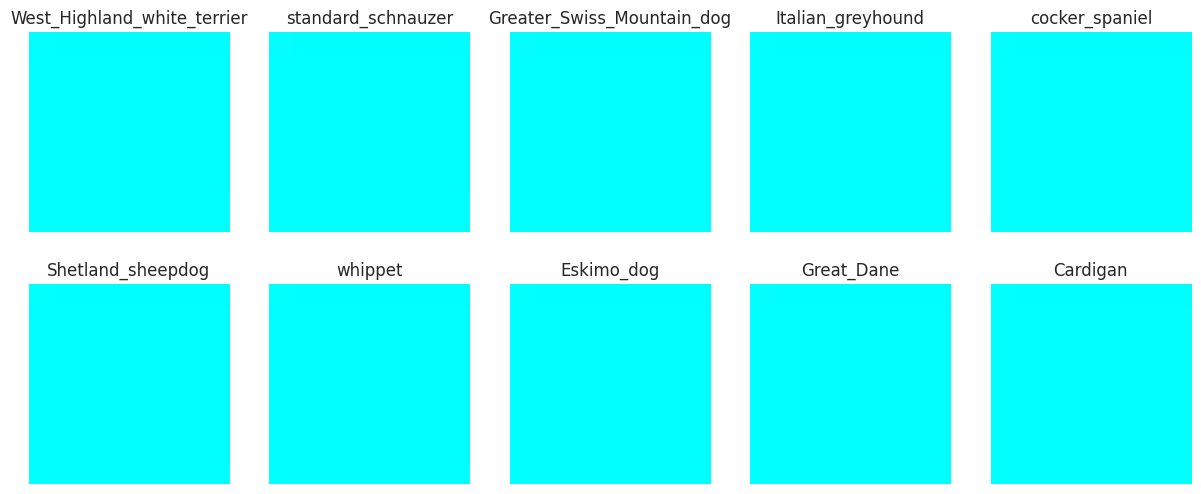


   -> Current resolution: 16 x 16 

Epoch 1/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.652     gen_loss=26.494     t=19s
Epoch 2/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.755     gen_loss=10.825     t=19s
Epoch 3/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.262     gen_loss=10.625     t=18s
Epoch 4/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.002     gen_loss=29.626     t=19s
Epoch 5/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=2.855     gen_loss=97.899     t=19s
Epoch 6/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.002     gen_loss=49.194     t=18s
Epoch 7/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.416     gen_loss=71.764     t=19s
Epoch 8/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.580     gen_loss=9.308     t=18s
Epoch 9/20     lr_g=6.0e-03     lr_d

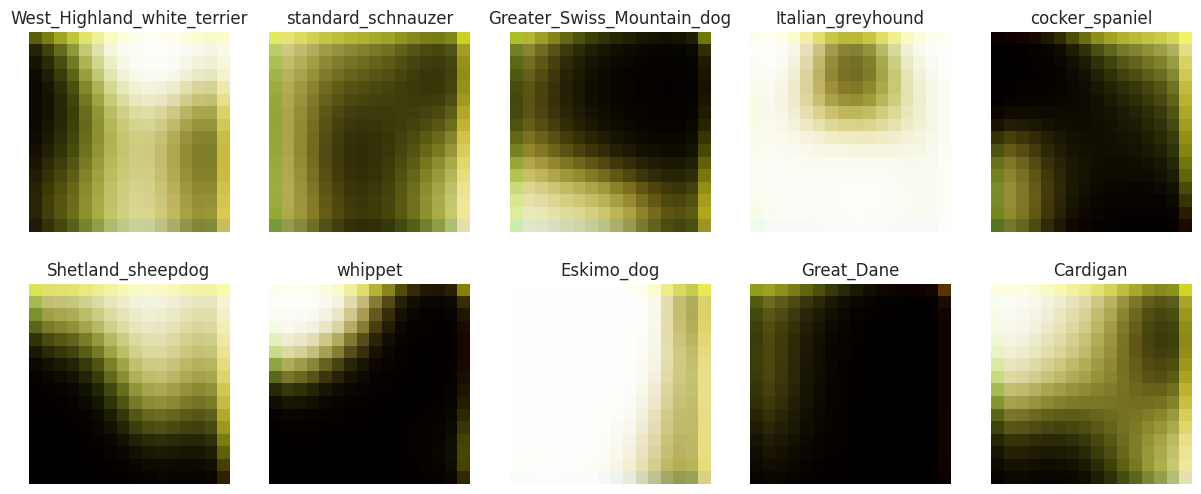

Epoch 11/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.514     gen_loss=2.857     t=17s
Epoch 12/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.894     gen_loss=2.055     t=17s
Epoch 13/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.817     gen_loss=1.897     t=17s
Epoch 14/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.613     gen_loss=2.219     t=17s
Epoch 15/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.759     gen_loss=2.046     t=19s
Epoch 16/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.842     gen_loss=1.829     t=19s
Epoch 17/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.914     gen_loss=1.730     t=19s
Epoch 18/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.994     gen_loss=1.624     t=18s
Epoch 19/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     d

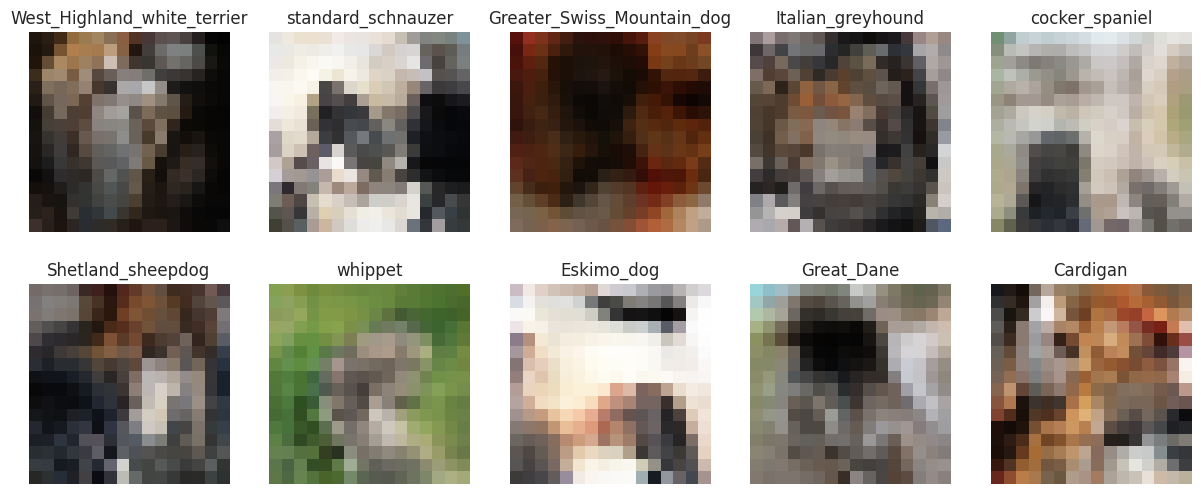


   -> Current resolution: 32 x 32 

Epoch 1/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.909     gen_loss=2.394     t=40s
Epoch 2/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.874     gen_loss=1.922     t=40s
Epoch 3/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.635     gen_loss=2.267     t=40s
Epoch 4/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.784     gen_loss=2.004     t=40s
Epoch 5/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.921     gen_loss=1.809     t=40s
Epoch 6/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.962     gen_loss=1.790     t=40s
Epoch 7/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.903     gen_loss=1.818     t=40s
Epoch 8/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.908     gen_loss=1.783     t=40s
Epoch 9/40     lr_g=6.0e-03     lr_d=6.0e-0

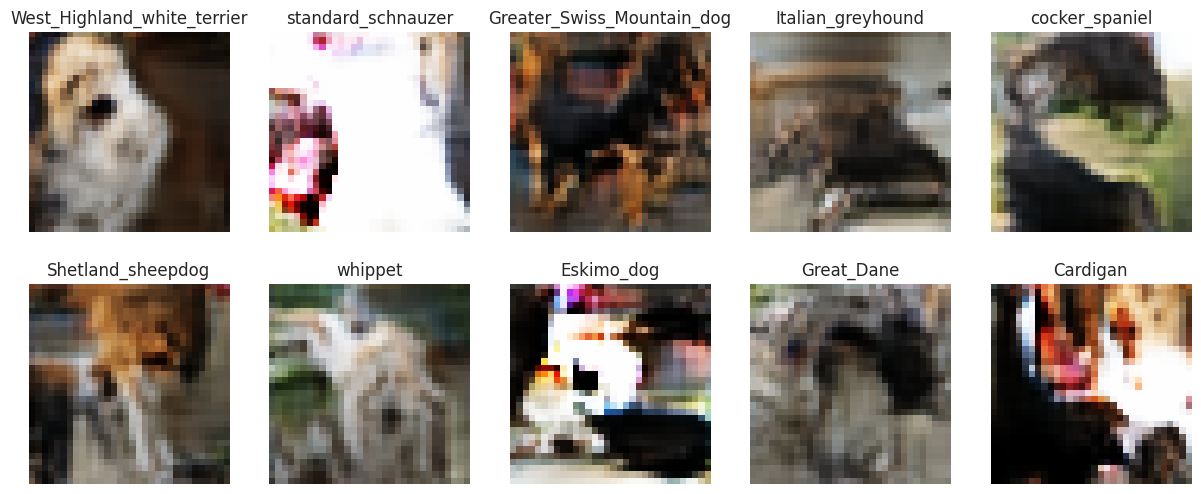

Epoch 11/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.857     gen_loss=1.835     t=40s
Epoch 12/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.824     gen_loss=1.834     t=40s
Epoch 13/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.760     gen_loss=1.916     t=40s
Epoch 14/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.786     gen_loss=1.949     t=40s
Epoch 15/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.756     gen_loss=2.042     t=40s
Epoch 16/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.783     gen_loss=2.050     t=40s
Epoch 17/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.764     gen_loss=2.035     t=40s
Epoch 18/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.751     gen_loss=2.087     t=40s
Epoch 19/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     d

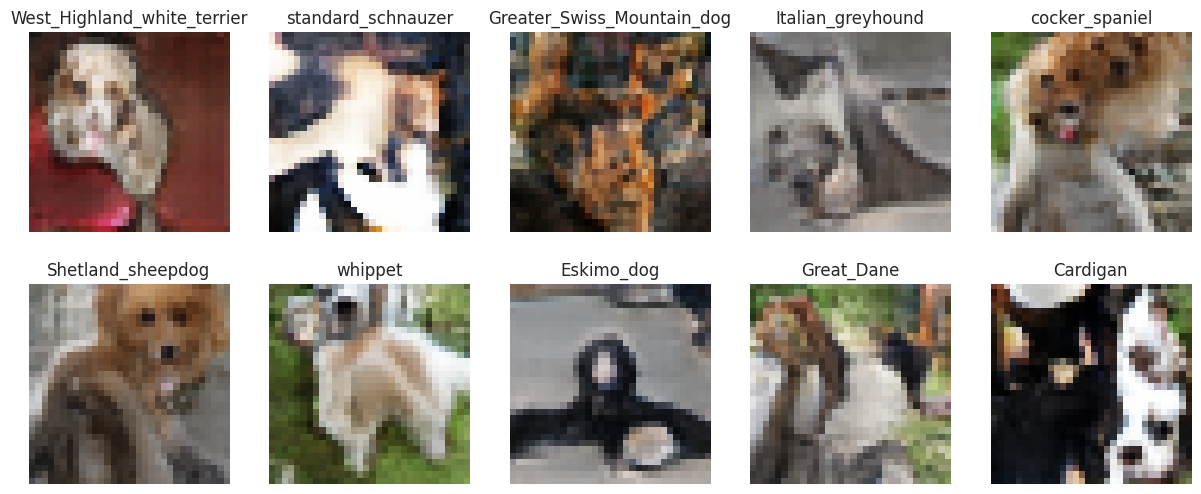

Epoch 21/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.704     gen_loss=2.255     t=40s
Epoch 22/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.685     gen_loss=2.359     t=40s
Epoch 23/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.700     gen_loss=2.321     t=40s
Epoch 24/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.706     gen_loss=2.424     t=40s
Epoch 25/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.687     gen_loss=2.492     t=40s
Epoch 26/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.692     gen_loss=2.497     t=40s
Epoch 27/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.679     gen_loss=2.553     t=40s
Epoch 28/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.664     gen_loss=2.613     t=40s
Epoch 29/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     d

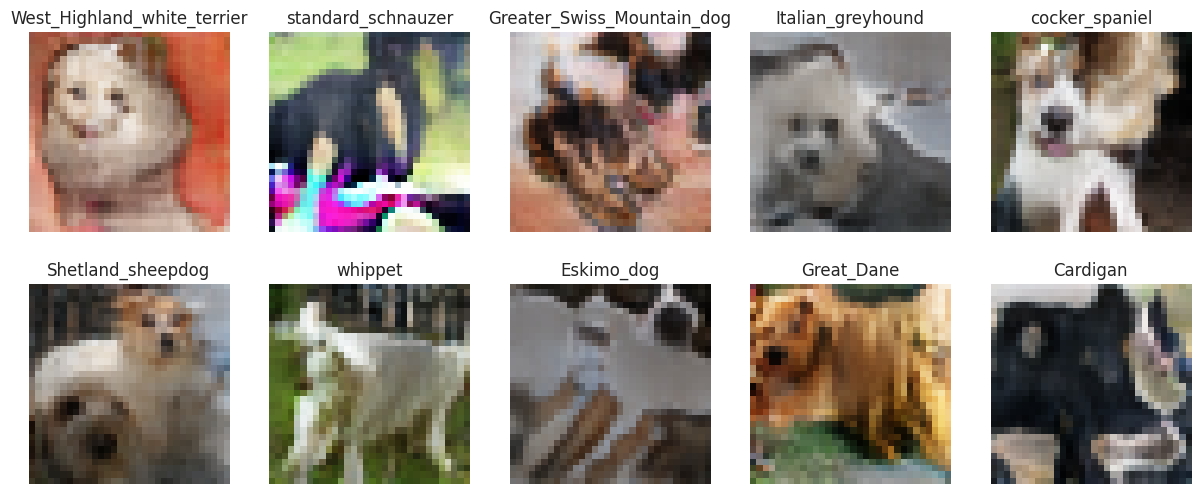

Epoch 31/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.646     gen_loss=2.713     t=40s
Epoch 32/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.646     gen_loss=2.791     t=40s
Epoch 33/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.617     gen_loss=2.865     t=40s
Epoch 34/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.606     gen_loss=2.948     t=40s
Epoch 35/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.702     gen_loss=2.856     t=40s
Epoch 36/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.655     gen_loss=2.885     t=40s
Epoch 37/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.620     gen_loss=2.936     t=40s
Epoch 38/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.630     gen_loss=2.931     t=40s
Epoch 39/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     d

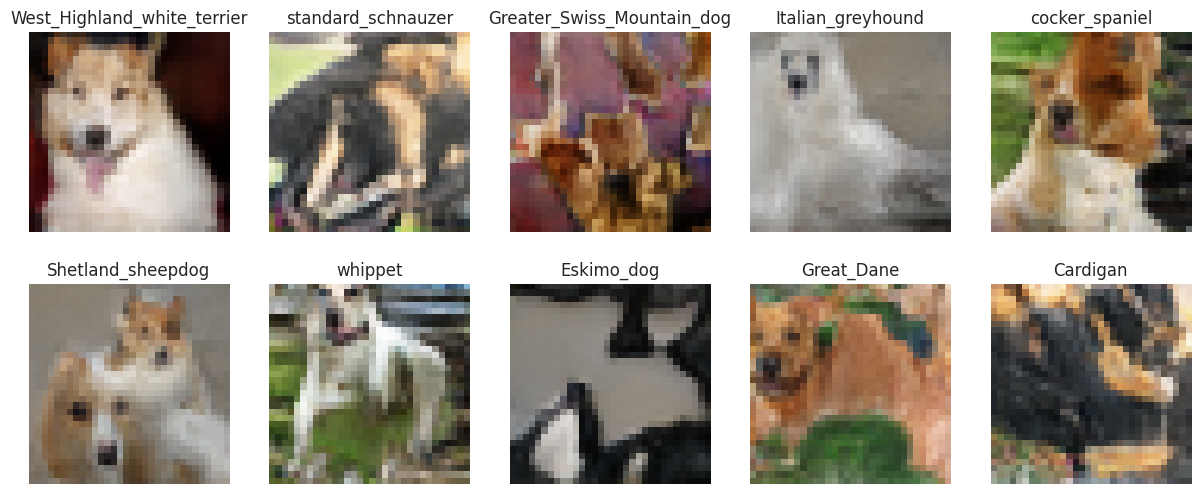


   -> Current resolution: 64 x 64 

Epoch 1/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.717     gen_loss=4.674     t=90s
Epoch 2/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.515     gen_loss=3.084     t=90s
Epoch 3/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.382     gen_loss=3.702     t=90s
Epoch 4/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.440     gen_loss=3.890     t=90s
Epoch 5/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.465     gen_loss=3.535     t=90s
Epoch 6/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.473     gen_loss=3.837     t=90s
Epoch 7/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.542     gen_loss=3.467     t=90s
Epoch 8/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.524     gen_loss=3.425     t=90s
Epoch 9/100     lr_g=6.0e-03     lr

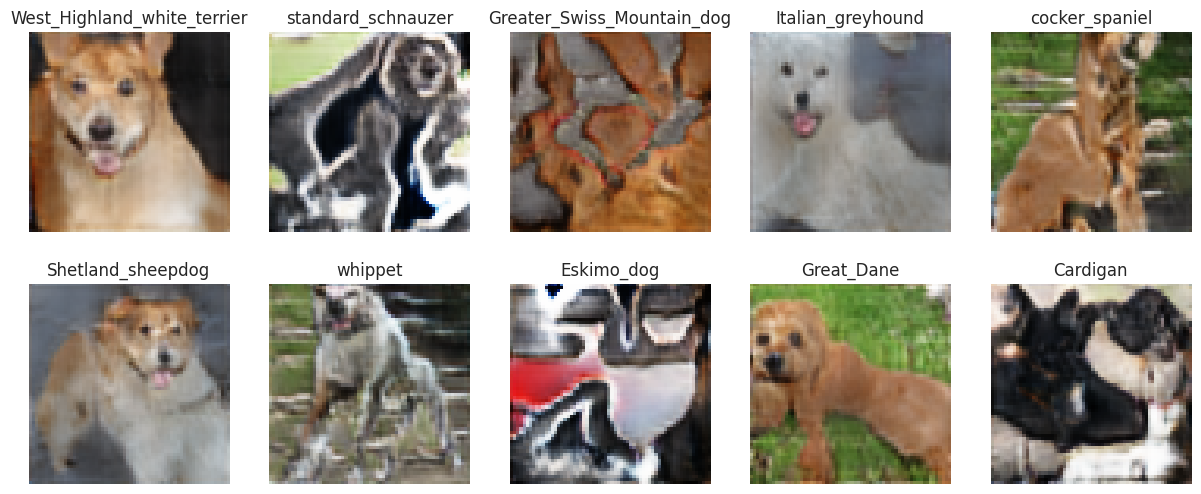

Epoch 11/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.604     gen_loss=3.305     t=90s
Epoch 12/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.592     gen_loss=3.433     t=90s
Epoch 13/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.612     gen_loss=3.280     t=90s
Epoch 14/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.588     gen_loss=3.325     t=90s
Epoch 15/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.624     gen_loss=3.240     t=90s
Epoch 16/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.581     gen_loss=3.368     t=90s
Epoch 17/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.594     gen_loss=3.339     t=90s
Epoch 18/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.619     gen_loss=3.258     t=90s
Epoch 19/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9

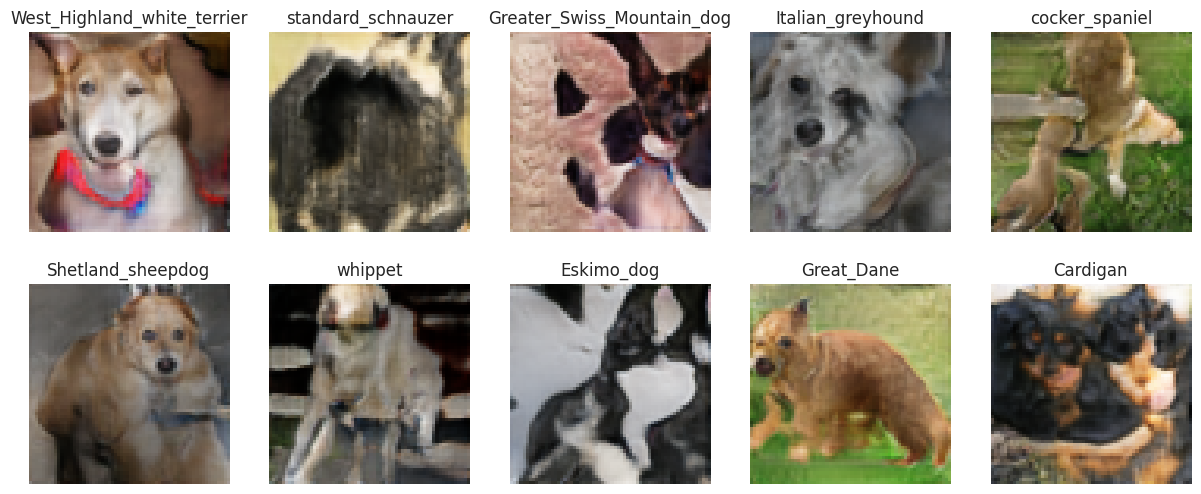

Epoch 21/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.599     gen_loss=3.482     t=90s
Epoch 22/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.558     gen_loss=3.468     t=91s
Epoch 23/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.548     gen_loss=3.608     t=90s
Epoch 24/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.550     gen_loss=3.506     t=90s
Epoch 25/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.603     gen_loss=3.542     t=90s


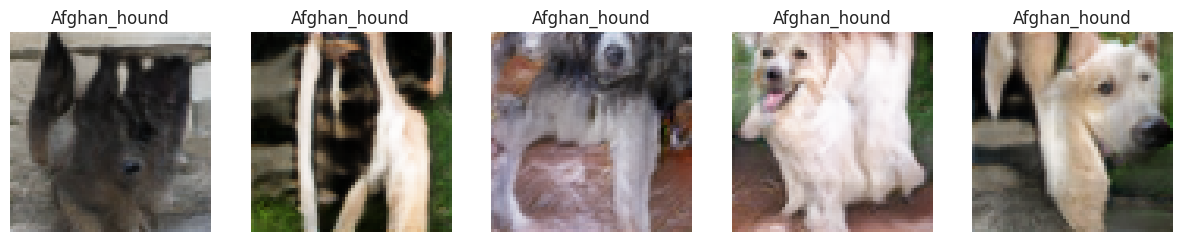

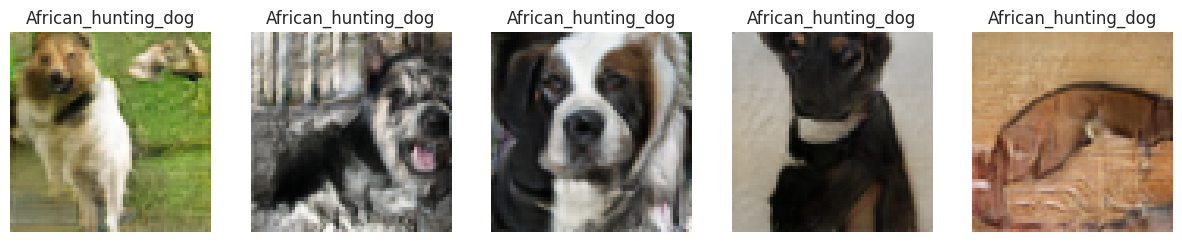

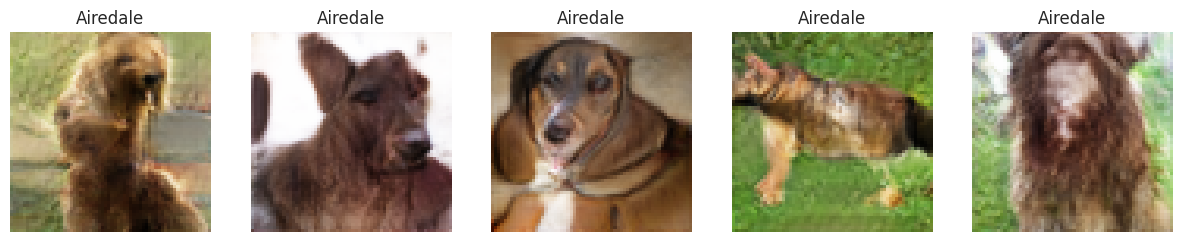

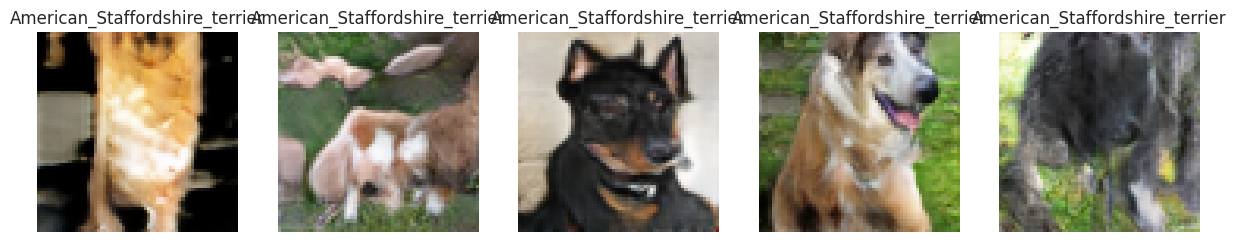

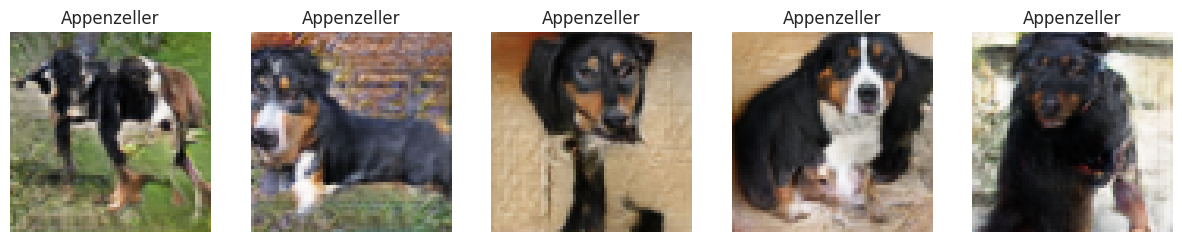

Epoch 26/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.560     gen_loss=3.539     t=90s
Epoch 27/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.552     gen_loss=3.587     t=90s
Epoch 28/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.538     gen_loss=3.658     t=90s
Epoch 29/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.501     gen_loss=3.777     t=90s
Epoch 30/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.530     gen_loss=3.682     t=90s


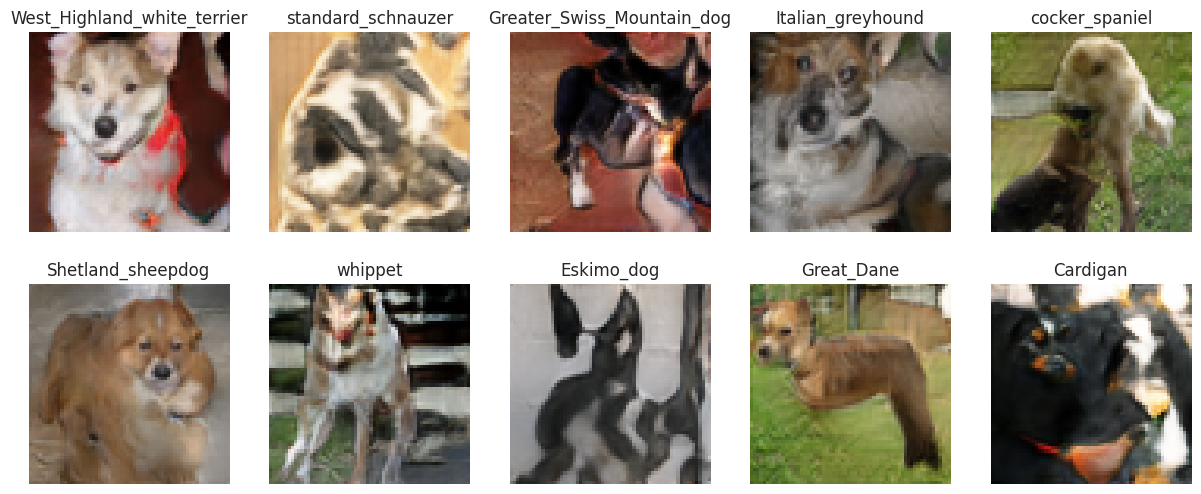

Epoch 31/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.522     gen_loss=3.701     t=90s
Epoch 32/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.502     gen_loss=3.875     t=90s
Epoch 33/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.496     gen_loss=3.750     t=90s
Epoch 34/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.515     gen_loss=3.770     t=90s
Epoch 35/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.477     gen_loss=3.914     t=90s
Epoch 36/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.490     gen_loss=3.904     t=90s
Epoch 37/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.460     gen_loss=3.954     t=90s
Epoch 38/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.465     gen_loss=3.990     t=90s
Epoch 39/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9

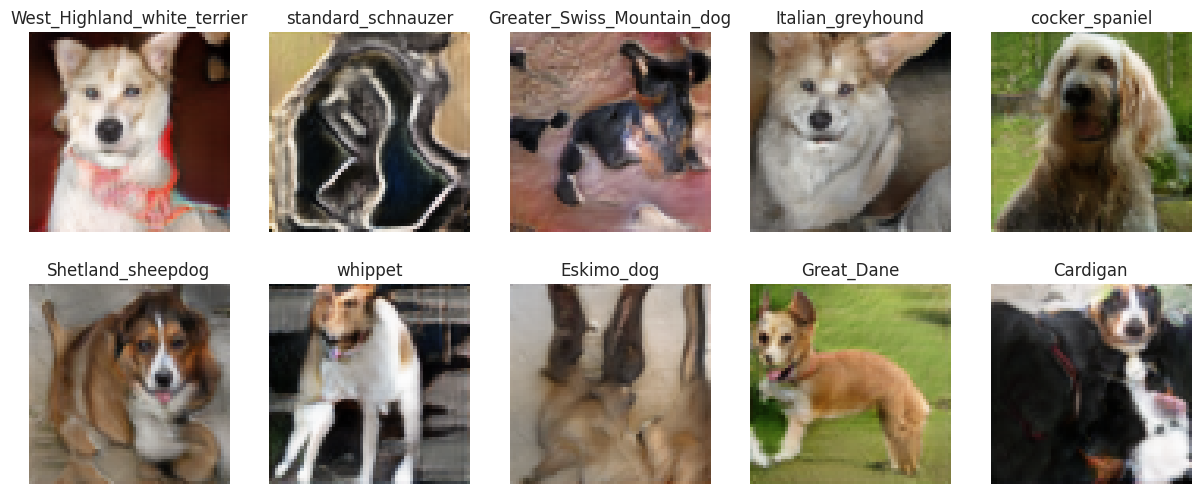

Epoch 41/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.429     gen_loss=4.146     t=90s
Epoch 42/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.429     gen_loss=4.209     t=90s
Epoch 43/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.432     gen_loss=4.185     t=90s
Epoch 44/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.425     gen_loss=4.274     t=90s
Epoch 45/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.398     gen_loss=4.383     t=90s
Epoch 46/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.420     gen_loss=4.354     t=90s
Epoch 47/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.437     gen_loss=4.182     t=90s
Epoch 48/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.430     gen_loss=4.189     t=90s
Epoch 49/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9

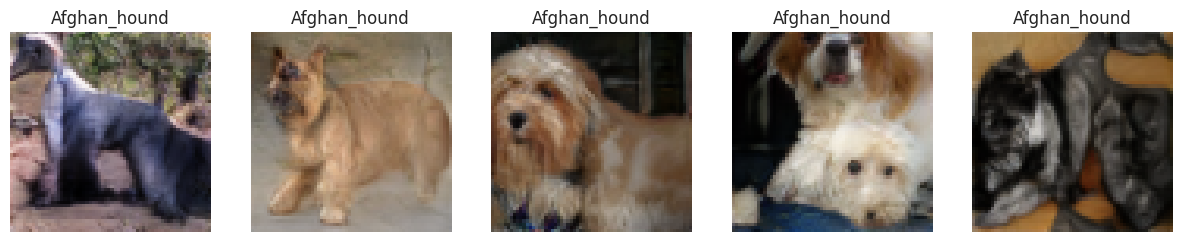

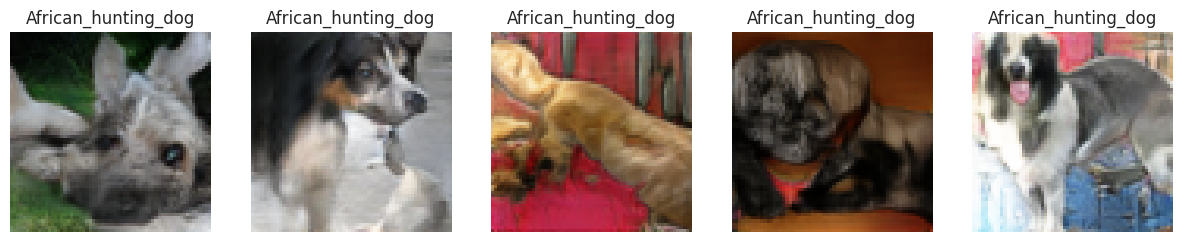

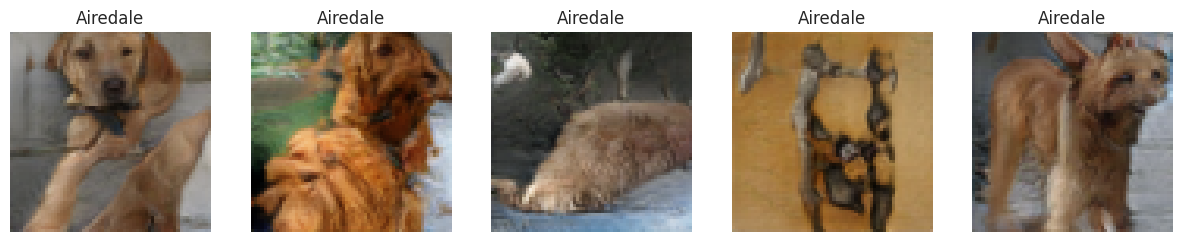

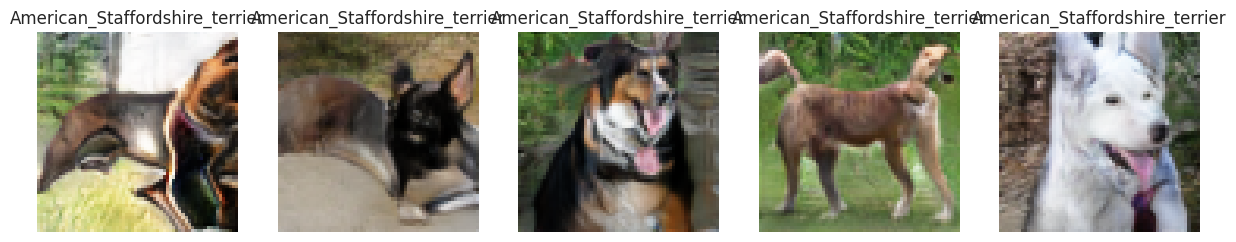

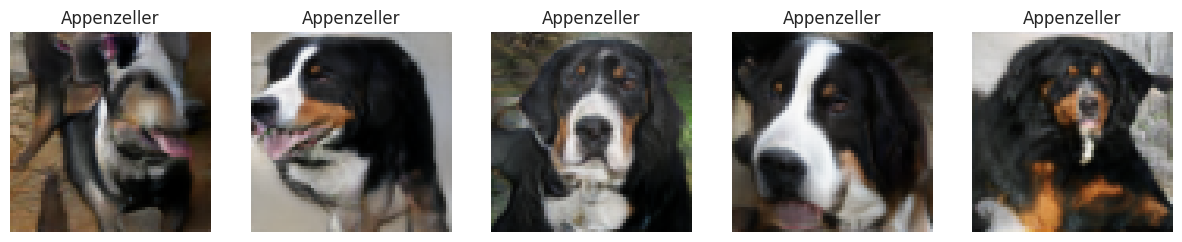

Epoch 51/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.410     gen_loss=4.413     t=90s
Epoch 52/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.411     gen_loss=4.419     t=90s
Epoch 53/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.377     gen_loss=4.541     t=90s
Epoch 54/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.409     gen_loss=4.570     t=90s
Epoch 55/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.374     gen_loss=4.802     t=90s
Epoch 56/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.380     gen_loss=4.613     t=90s
Epoch 57/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.364     gen_loss=4.602     t=90s
Epoch 58/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.372     gen_loss=4.641     t=90s
Epoch 59/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9

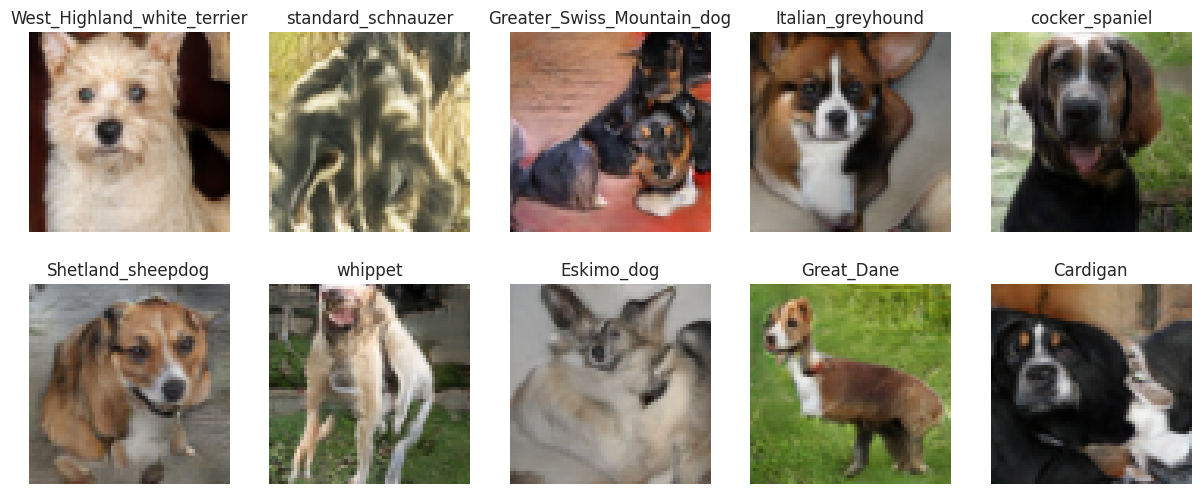

Epoch 61/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.365     gen_loss=4.696     t=90s
Epoch 62/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.383     gen_loss=4.671     t=90s
Epoch 63/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.359     gen_loss=4.855     t=90s
Epoch 64/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.360     gen_loss=4.729     t=90s
Epoch 65/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.364     gen_loss=4.932     t=90s
Epoch 66/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.353     gen_loss=4.826     t=90s
Epoch 67/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.382     gen_loss=4.547     t=90s
Epoch 68/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.357     gen_loss=4.753     t=90s
Epoch 69/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9

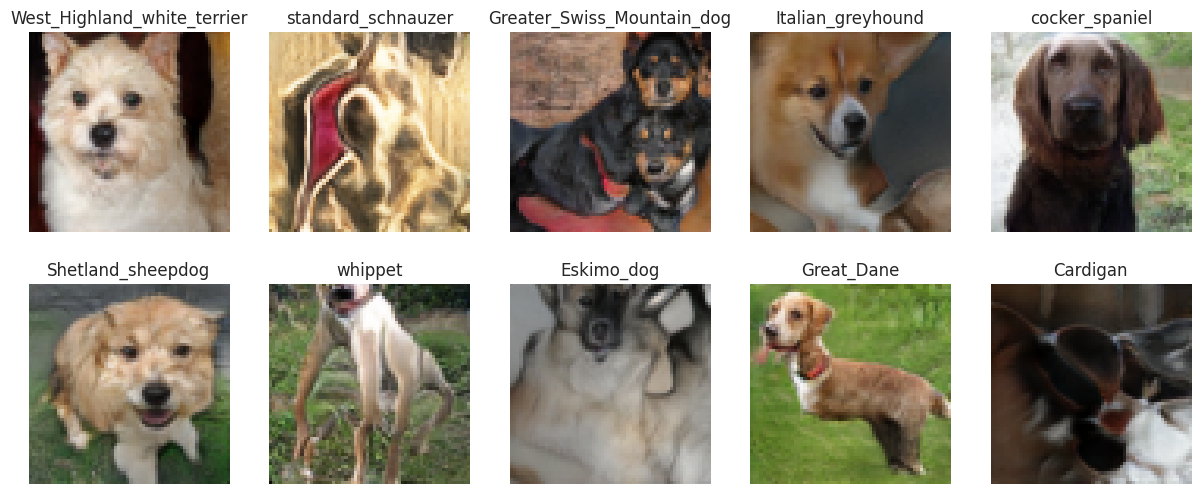

Epoch 71/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.305     gen_loss=5.006     t=90s
Epoch 72/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.347     gen_loss=5.071     t=90s
Epoch 73/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.344     gen_loss=5.023     t=90s
Epoch 74/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.358     gen_loss=4.760     t=90s
Epoch 75/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.343     gen_loss=5.200     t=90s


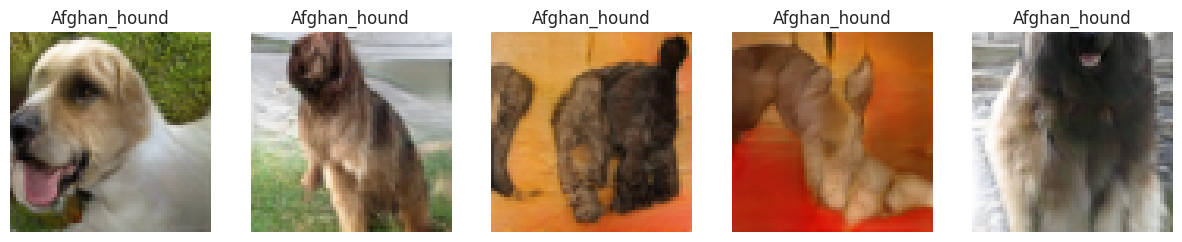

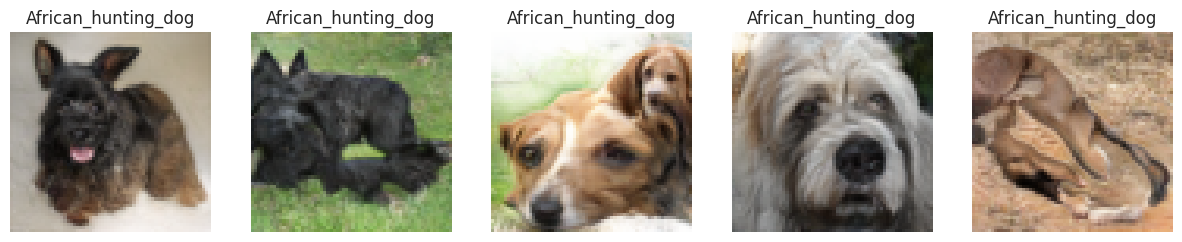

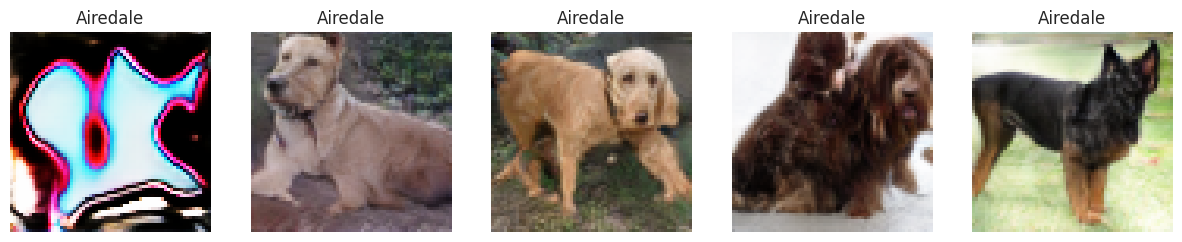

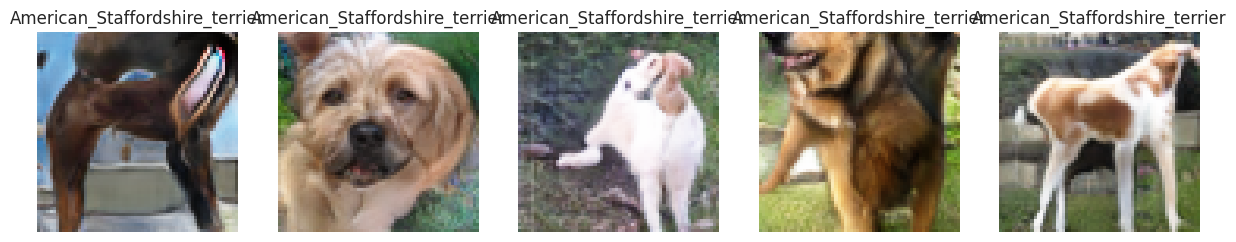

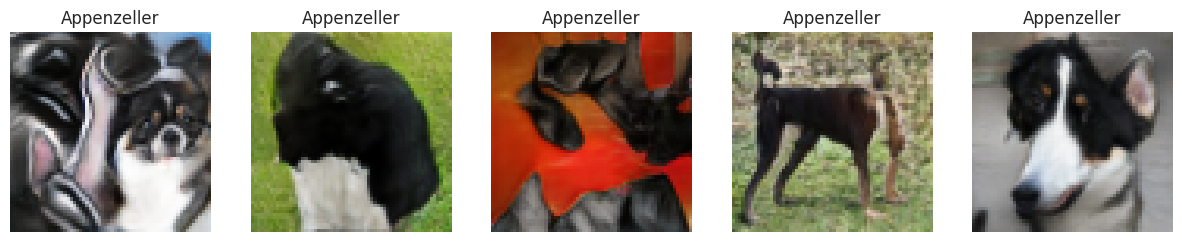

Epoch 76/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.344     gen_loss=4.877     t=90s
Epoch 77/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.318     gen_loss=5.074     t=90s
Epoch 78/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.312     gen_loss=5.234     t=90s
Epoch 79/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.381     gen_loss=5.026     t=90s
Epoch 80/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.313     gen_loss=5.024     t=90s


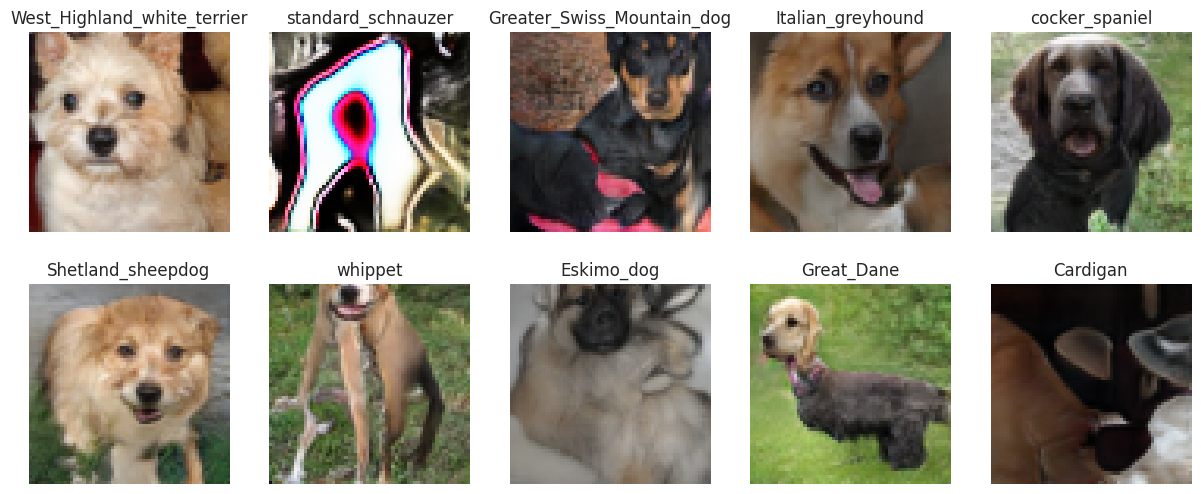

Epoch 81/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.343     gen_loss=5.313     t=90s
Epoch 82/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.338     gen_loss=5.023     t=90s
Epoch 83/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.316     gen_loss=5.064     t=90s
Epoch 84/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.346     gen_loss=5.024     t=90s
Epoch 85/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.330     gen_loss=5.166     t=90s
Epoch 86/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.322     gen_loss=5.130     t=90s
Epoch 87/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.311     gen_loss=5.418     t=90s
Epoch 88/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.363     gen_loss=5.030     t=90s
Epoch 89/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9

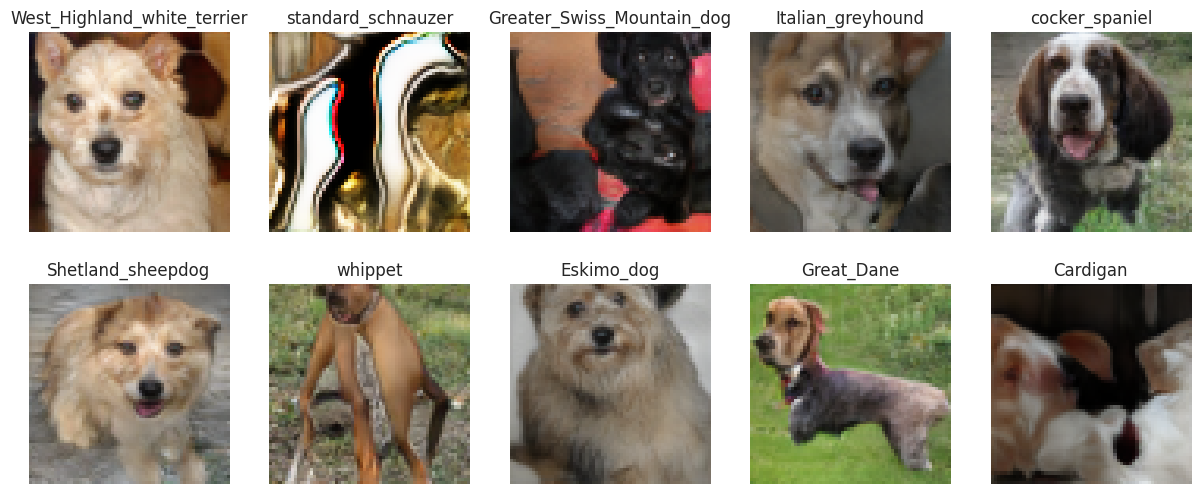

Epoch 91/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.310     gen_loss=5.372     t=90s
Epoch 92/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.317     gen_loss=5.240     t=90s
Epoch 93/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.333     gen_loss=5.149     t=90s
Epoch 94/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.300     gen_loss=5.669     t=90s
Epoch 95/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.305     gen_loss=5.541     t=90s
Epoch 96/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.279     gen_loss=5.587     t=90s
Epoch 97/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.285     gen_loss=5.594     t=90s
Epoch 98/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.347     gen_loss=5.579     t=90s
Epoch 99/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9

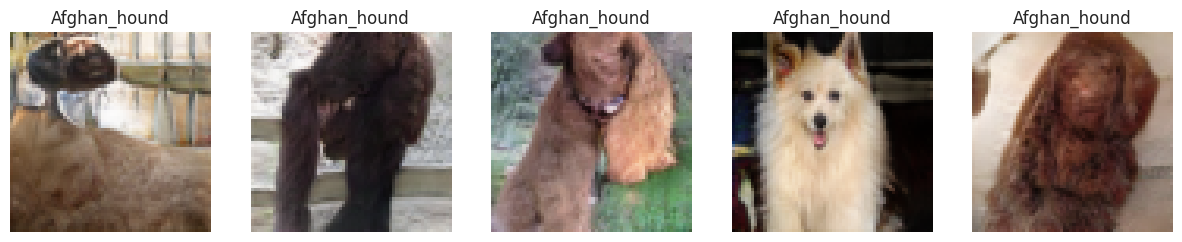

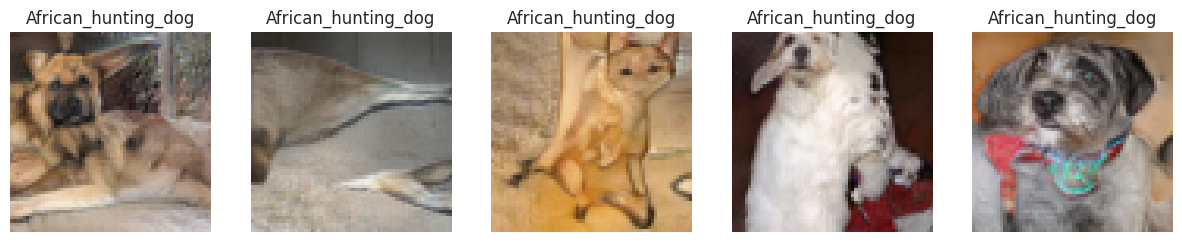

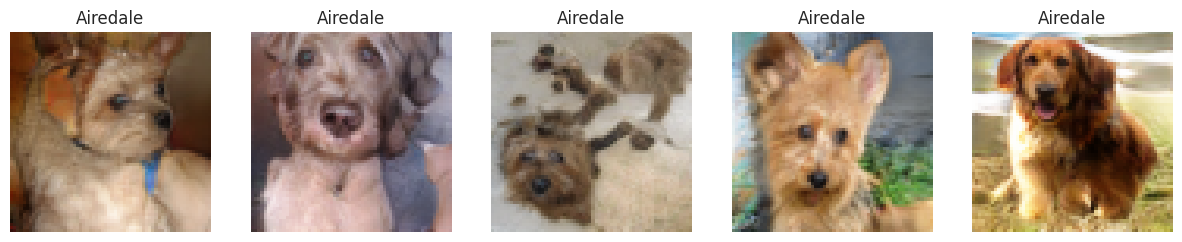

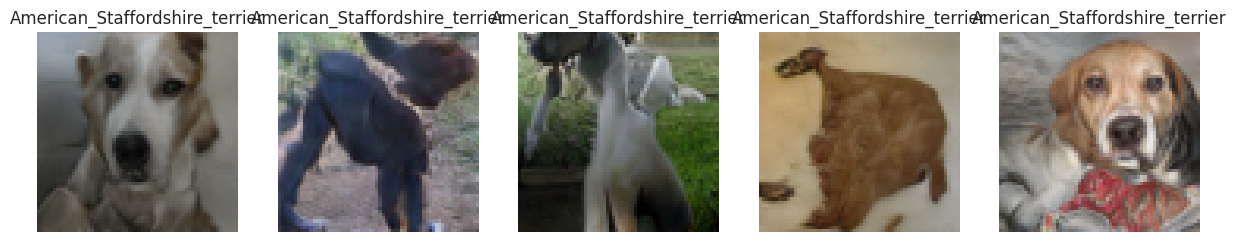

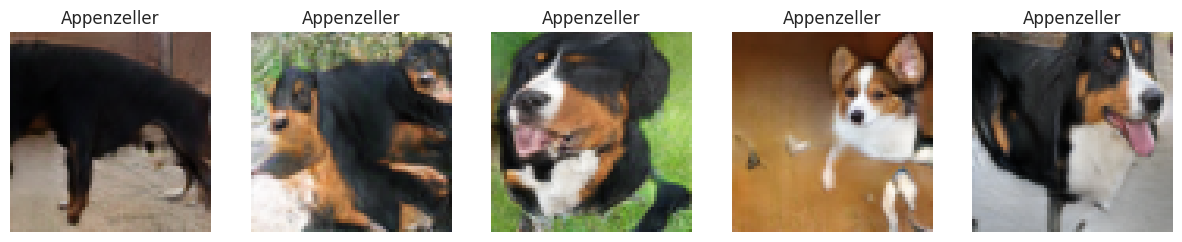

In [ ]:
infos = pro_gan.train(
    dataset=dataset,
    epochs=num_epochs,
    fade_in_percentage=fade_ins,
    batch_sizes=batch_sizes,
    ema_decays=ema_decays,
    verbose=1
)

Storing the Weights

In [ ]:
save_model_weights(pro_gan.gen, "gen_weights.pt")
save_model_weights(pro_gan.gen_shadow, "gen_shadow_weights.pt")
save_model_weights(pro_gan.dis, "dis_weights.pt")


-> Saving weights to gen_weights.pt
-> Saving weights to gen_shadow_weights.pt
-> Saving weights to dis_weights.pt


Plotting the loss

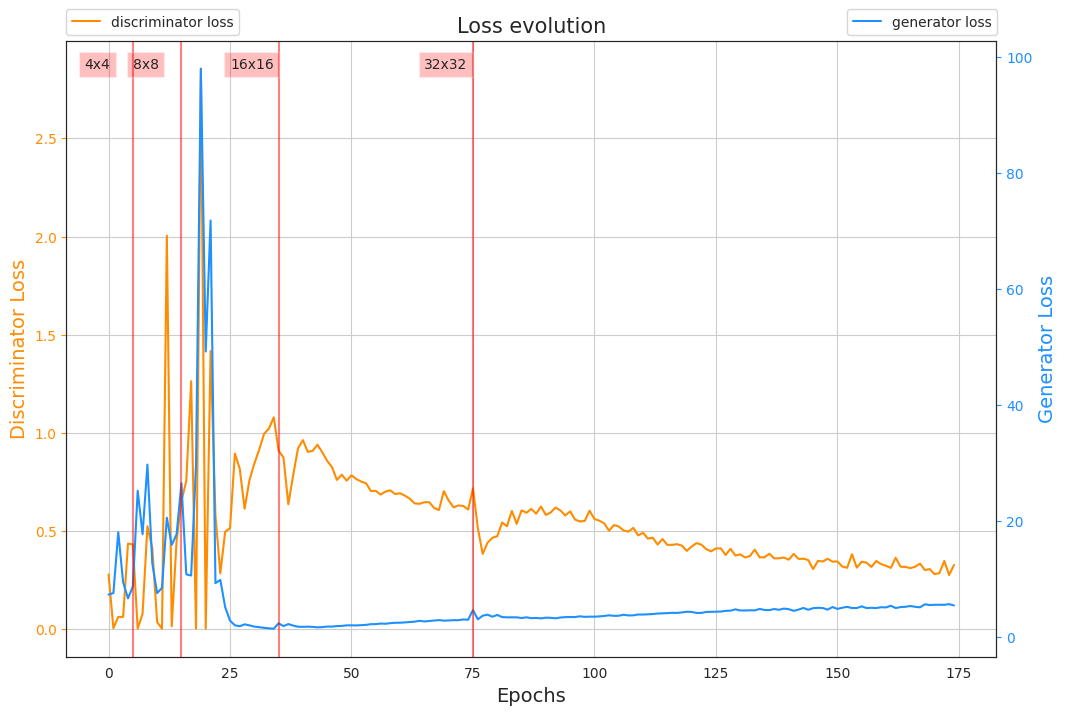

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 8))

plt.plot(infos['discriminator_loss'], label='discriminator loss', c='darkorange')
ax1.set_ylabel('Discriminator Loss', color='darkorange', size=14)
ax1.tick_params(axis='y', colors='darkorange')
ax1.set_xlabel('Epochs', size=14)
plt.grid(True)
plt.legend(loc=(0, 1.01))

ax2 = ax1.twinx()
plt.plot(infos['generator_loss'], label='generator loss', c='dodgerblue')
ax2.set_ylabel('Generator Loss', color='dodgerblue', size=14)
ax2.tick_params(axis='y', colors='dodgerblue')
plt.legend(loc=(0.84, 1.01))

res = 4
for epoch in np.cumsum(num_epochs[:-1]):
    plt.axvline(epoch, c='r', alpha=0.5)
    plt.text(x=epoch-10, y=np.max(infos['generator_loss']), s=f'{res}x{res}', bbox=dict(facecolor='red', alpha=0.25))
    res *= 2

plt.title('Loss evolution', size=15)
plt.show()

Generating 50 images

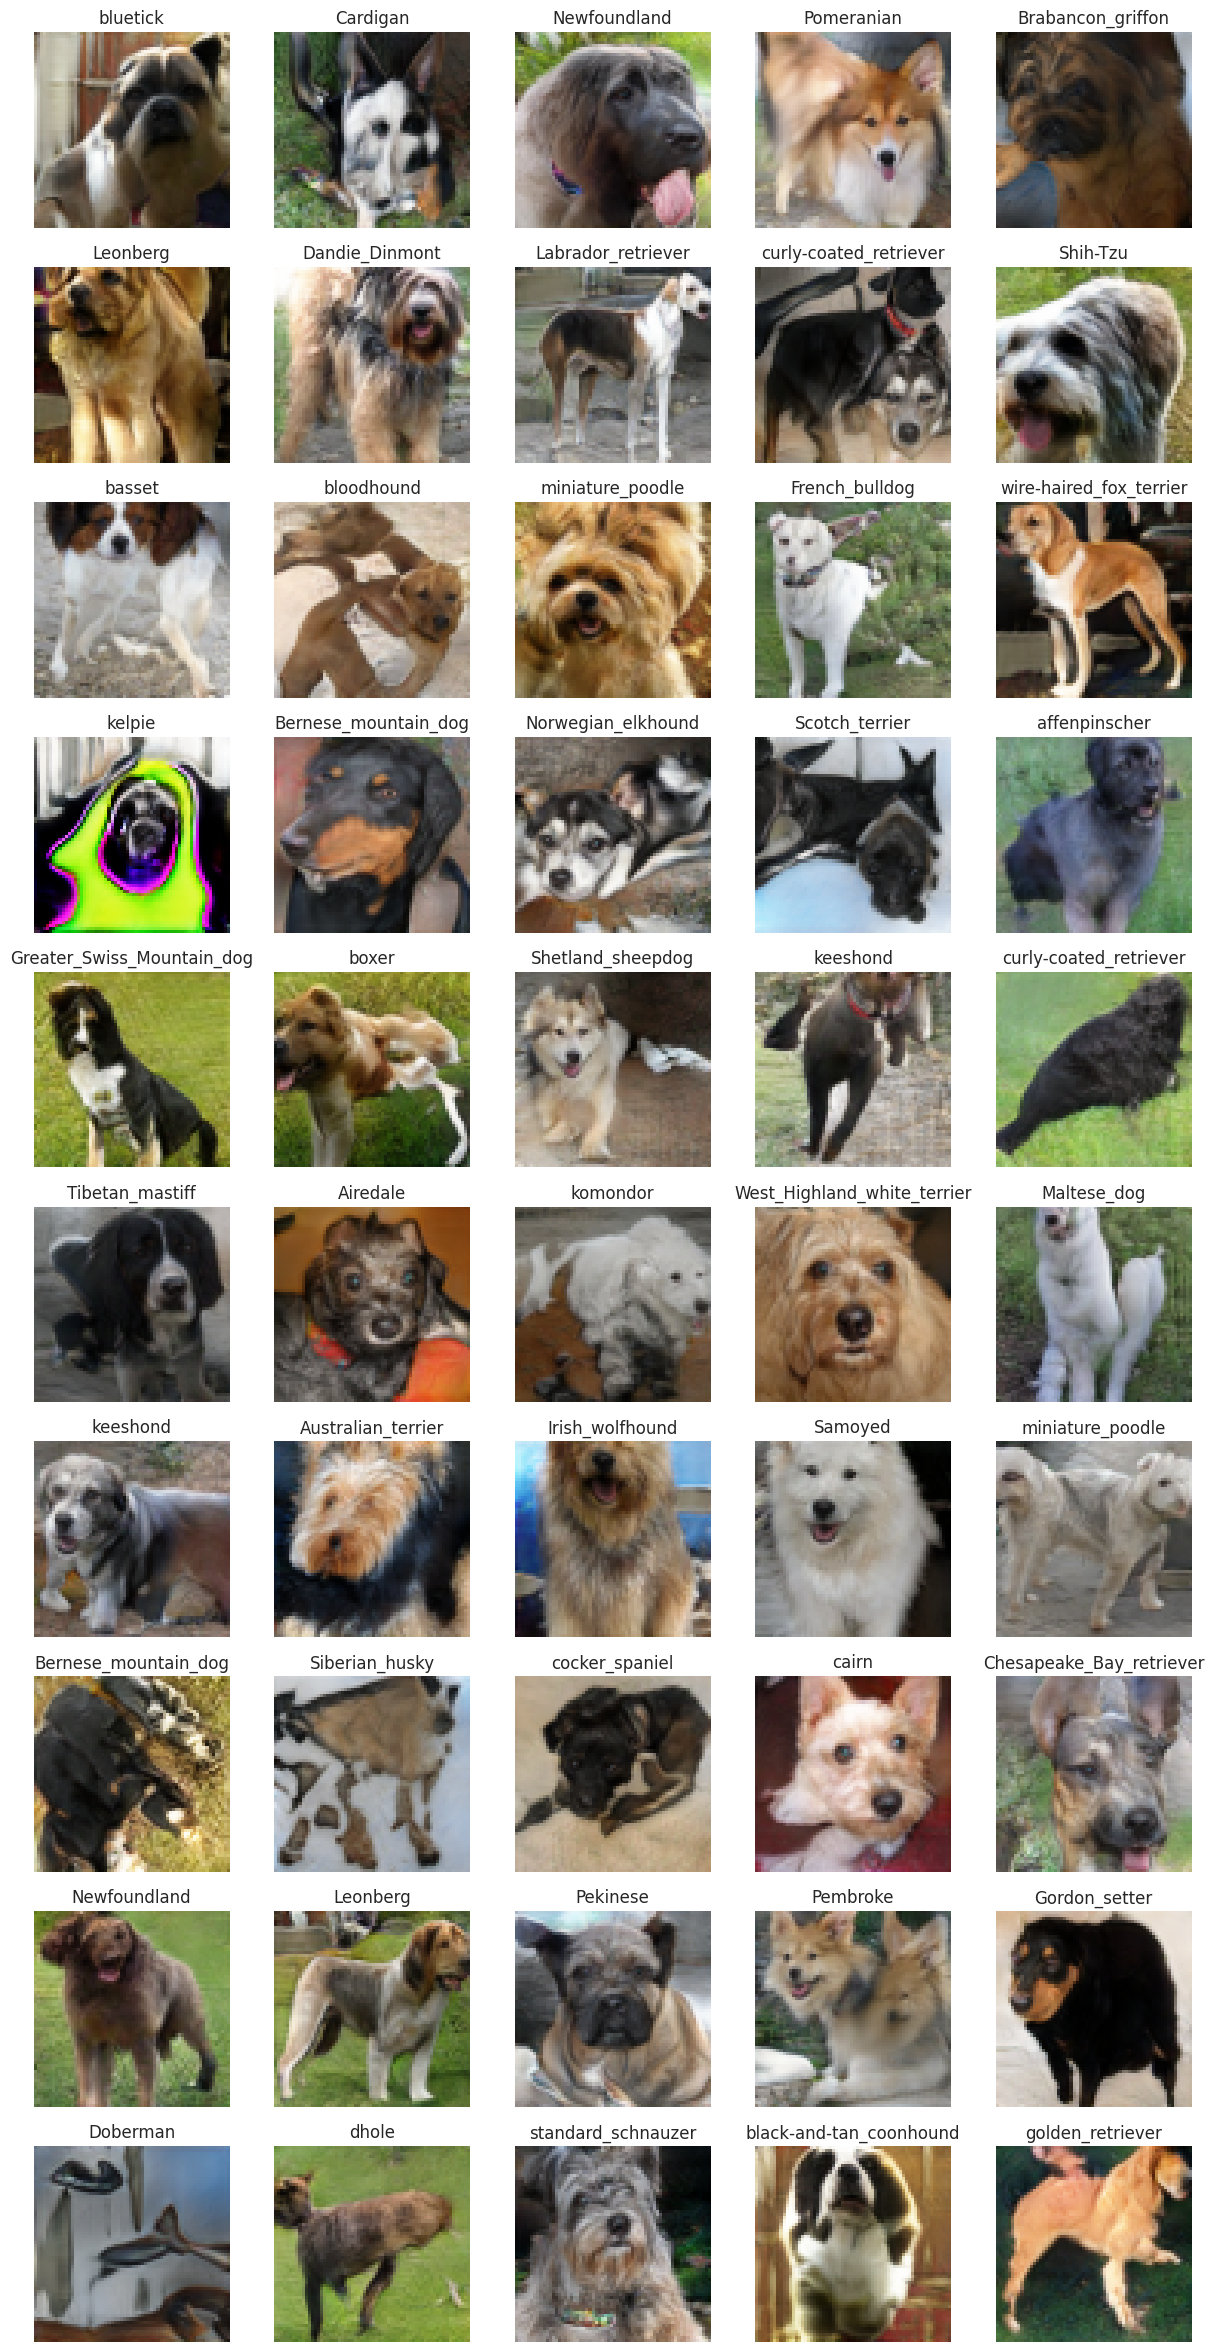

In [ ]:
_ = pro_gan.generate(n_plot=50, n=batch_sizes[0])

In [ ]:
use_class_probs = False


Keeping the similar class as the given images, generating 10000 images

In [ ]:
class_mifids = {0: 59.588, 1: 72.73, 2: 67.551, 3: 55.2313, 4: 106.411, 5: 91.73, 6: 76.835, 7: 116.532, 8: 133.186, 9: 97.613, 10: 60.579, 11: 88.973, 12: 100.450, 13: 70.434, 14: 109.0, 15: 67.517, 16: 70.190, 17: 64.704, 18: 93.84, 19: 85.469, 20: 76.62, 21: 59.845, 22: 88.898, 23: 106.39, 24: 82.955, 25: 65.451, 26: 58.066, 27: 51.016, 28: 86.535, 29: 55.7707, 30: 101.185, 31: 107.090, 32: 72.13, 33: 82.097, 34: 75.549, 35: 101.369, 36: 58.6547, 37: 58.2671, 38: 119.541, 39: 102.502, 40: 50.871, 41: 62.708, 42: 68.374, 43: 91.805, 44: 121.485, 45: 63.633, 46: 81.873, 47: 84.495, 48: 70.738, 49: 86.552, 50: 88.067, 51: 71.89, 52: 94.634, 53: 113.624, 54: 83.190, 55: 98.981, 56: 95.340, 57: 64.076, 58: 117.179, 59: 88.268, 60: 72.986, 61: 98.971, 62: 85.285, 63: 85.808, 64: 79.254, 65: 64.701, 66: 86.365, 67: 70.703, 68: 93.268, 69: 86.699, 70: 52.1906, 71: 113.921, 72: 97.362, 73: 91.260, 74: 86.280, 75: 79.446, 76: 93.833, 77: 90.210, 78: 78.724, 79: 71.74, 80: 63.501, 81: 68.04, 82: 63.95, 83: 64.699, 84: 67.830, 85: 74.525, 86: 95.0, 87: 80.052, 88: 66.01, 89: 82.810, 90: 89.005, 91: 70.746, 92: 71.503, 93: 74.91, 94: 93.378, 95: 82.145, 96: 83.216, 97: 82.569, 98: 65.660, 99: 104.155, 100: 92.105, 101: 81.490, 102: 61.454, 103: 93.271, 104: 75.405, 105: 64.791, 106: 67.661, 107: 96.165, 108: 66.574, 109: 80.197, 110: 89.485, 111: 98.295, 112: 73.864, 113: 59.862, 114: 61.0195, 115: 86.696, 116: 71.2, 117: 91.355, 118: 62.981, 119: 65.444}

In [ ]:
probs = [class_mifids[k] for k in class_mifids.keys()]
probs = (probs - np.min(probs)) / np.sum(probs) / 4
probs = np.clip((1/120 - probs), 1/1000, 1/50)
probs /= np.sum(probs)

In [ ]:
im_batch_size = 100
n_images = 10000

In [ ]:
threshold = 200 # All classes are kept
kept_classes = [k for k in class_mifids.keys() if class_mifids[k] < threshold]
print(f'Kept {len(kept_classes)} classes')

Kept 120 classes


In [ ]:
if os.path.exists('/content/drive/MyDrive/Project//output_images'):
    shutil.rmtree('/content/drive/MyDrive/Project//output_images', ignore_errors=True)
os.mkdir('/content/drive/MyDrive/Project/output_images')

In [ ]:
for i_batch in tqdm(range(0, n_images, im_batch_size)):
    if use_class_probs:
        races = np.random.choice(kept_classes, size=im_batch_size, p=probs)
        races = torch.from_numpy(races).long()
        gen_images = pro_gan.generate(races=races, n=im_batch_size)
    else:
        gen_images = pro_gan.generate(n=im_batch_size)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('/content/drive/MyDrive/Project/output_images', f'img_{i_batch+i_image}.png'))

<ipython-input-70-4eaf8d57730e>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i_batch in tqdm(range(0, n_images, im_batch_size)):


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
print('Number of generated images :', len(os.listdir('/content/drive/MyDrive/Project/output_images')))


Number of generated images : 10000


#Evaluation Metric:
1. FID Score
2. SSIM Score

In [ ]:
# paths to directories containing the real and generated images
real_image_dir = '/content/drive/MyDrive/Project/all-dogs'
gen_image_dir = '/content/drive/MyDrive/Project/output_images'



In [1]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
import torch
from scipy.linalg import sqrtm
from torchvision.models import inception_v3


class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_list[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


def calculate_fid_score(dataloader1, dataloader2, dims=2048, device='cuda'):
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()

    def get_features(dataloader):
        features = []
        for img in dataloader:
            img = img.to(device)
            with torch.no_grad():
                pred = model(img)
            features.append(pred.cpu().numpy())
        features = np.concatenate(features, 0)
        return features

    f1 = get_features(dataloader1)
    f2 = get_features(dataloader2)
    m1, s1 = f1.mean(axis=0), np.cov(f1, rowvar=False)
    m2, s2 = f2.mean(axis=0), np.cov(f2, rowvar=False)
    diff = m1 - m2
    covmean, _ = sqrtm(s1.dot(s2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid_score = diff.dot(diff) + np.trace(s1) + np.trace(s2) - 2 * np.trace(covmean)
    return fid_score

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to 299x299
    transforms.ToTensor(),          # Convert PIL Image to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Create datasets
real_dataset = CustomDataset(real_image_dir, transform=transform)
gen_dataset = CustomDataset(gen_image_dir, transform=transform)

# Create dataloaders
real_dataloader = DataLoader(real_dataset, batch_size=50)
gen_dataloader = DataLoader(gen_dataset, batch_size=50)

# Calculate FID score
fid_score = calculate_fid_score(real_dataloader, gen_dataloader)
print('FID Score:', fid_score)


FID Score: 56.784500321


In [17]:
import glob
import os
import random
import numpy as np


def calculate_ssim(real_dir, generated_dir):
    real_images = []
    generated_images = []

    # Get image file names from directory
    real_image_files = glob.glob(os.path.join(real_dir, '*.jpg'))
    generated_image_files = glob.glob(os.path.join(generated_dir, '*.png'))

    # Log the number of images in each directory
    # print(f"Number of images in real_dir: {len(real_image_files)}")
    # print(f"Number of images in generated_dir: {len(generated_image_files)}")

    # Randomly shuffle the file names
    random.shuffle(real_image_files)
    random.shuffle(generated_image_files)

    # Select 500 images from each directory
    selected_real_files = random.sample(real_image_files, 500)
    selected_generated_files = random.sample(generated_image_files, 500)

    for real_file, generated_file in zip(selected_real_files, selected_generated_files):
        real_image = Image.open(real_file).convert('RGB')
        generated_image = Image.open(generated_file).convert('RGB')

        # Resize images to a common size if they have different dimensions
    if len(real_image_files) >= 500:
        selected_real_files = random.sample(real_image_files, 500)
    else:
        selected_real_files = real_image_files

    if len(generated_image_files) >= 500:
        selected_generated_files = random.sample(generated_image_files, 500)
    else:
        selected_generated_files = generated_image_files

    # Calculate the mean SSIM score
    ssim_scores = []
    for real_image, generated_image in zip(real_images, generated_images):
        real_image = np.array(real_image)
        generated_image = np.array(generated_image)
        ssim_score = ssim(real_image, generated_image, multichannel=True)
        ssim_scores.append(ssim_score)

    mean_ssim = np.mean(ssim_scores)

    return mean_ssim

In [19]:
real_image_dir = '/content/drive/MyDrive/Project/all-dogs'
gen_image_dir = '/content/drive/MyDrive/Project/output_images'

ss_score = calculate_ssim(real_image_dir, gen_image_dir)
print(f'The Structural Similarity Score of the model is {ss_score:0.3}')

The Structural Similarity Score of the model is 0.367
